# NMD effects in steady-state RNA expression

In this notebook we investigate if we can detect nonsense-mediated decay (NMD) effects in gene expression. Standard RNA sequencing measures polyadenylated steady-state RNA in tye cytosol (here refered to as "polyA"). Presumably these cytosolic RNA molecules already underwent splicing and degradation through NMD. We will compare polyA protein coding expression with the expression observed in nascent RNA (chRNA), newly transcribed RNA (4sU labelled RNA). chRNA and 4sU RNA presumably captures RNA molecules during the process of transcription and splicing, and some before degradation through NMD. Thus by comparing the differences in gene expression with the observed expression in polyA, we should be able to capture some of the variance attributable to NMD.

We will corroborate by comparing polyA gene expression with histone marks coverage at the TSS of a Gene. Histone marks at the TSS should capture some of the gene expression variance attreibutable to transcription, but none of the variance associated with splicing and NMD.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr, spearmanr, zscore
from tqdm import tqdm
import sys

sys.path.append('../code/scripts/useful_modules')

# Some useful functions for plotting that I wrote previously
from plot_functions import *
from regression_functions import *

# The data
First we load gene expression data for multiple assays: chRNA, 4sU 30min, 3sU 60min, and polyA. Here I am using Ben's trimmed and remapped data to the basic gencode gtf annotation. This should help to quantify gene expression solely on protein coding isoforms of protein coding genes.

In [2]:
# load RPKM data

all_RPKM = pd.read_csv(
    '../code/ReadLengthMapExperimentResults/tables/AllRNASeq.Normalized.RPKM.bed.gz', sep='\t',
                   index_col=3)

CDS_len = all_RPKM.Length
gene_len = all_RPKM.end - all_RPKM.start

chRNA_samples = [x for x in all_RPKM.columns if x.split('.')[0] == 'chRNA']
polyA_samples = [x for x in all_RPKM.columns if x.split('.')[0] == 'polyA']
ml30_samples = [x for x in all_RPKM.columns if x.split('.')[0] == 'RNA30min']
ml60_samples = [x for x in all_RPKM.columns if x.split('.')[0] == 'RNA60min']
shared_samples = [x.split('.')[1] for x in chRNA_samples]

Now let's get the splice junction reads form chRNA obtained by Leafcutter, Ben's new intron annotation, plus some useful information. This will be used to calculate the percent of observed junctions on a gene that are NMD (%NMD).

In [3]:
# Load junction annotation 
annot = pd.read_csv('../data/IntronAnnotationsFromYang.tsv.gz', 
                    sep='\t',)
annot['junction_id'] = annot[['chrom','start', 'end', 'strand']].astype(str).agg(':'.join, axis=1)

# Getting tables of splice junctions for chRNA, and selecting shared samples
# to reduce external variance.
chRNA_juncs = pd.read_csv('../code/SplicingAnalysis/NMDJunctions/tables/leafcutter_perind.counts_only.chRNA.Expression.Splicing.bed.gz', 
                          sep='\t')
chRNA_juncs_cols = list(chRNA_juncs.columns[:6]) + shared_samples
chRNA_juncs = chRNA_juncs[chRNA_juncs_cols]


# Define sets of interesting junction types for Ben's annotation

nmd_list_only = ['predicted_NMD YN', 'predicted_NMD pstopcodon', 
                 'predicted_NMD far3p', 'predicted_NMD UTRjunction',
                 'predicted_NMD far5p', 'uniquely nonsense_mediated_decay tag',
                 'predicted_NMD reason2', 'overlaps nonsense_mediated_decay intron',
                 'predicted_NMD NN', 'predicted_NMD reason1']


nmd_list = ['AnnotatedJunc_UnproductiveCodingGene',
            'UnannotatedJunc_UnproductiveCodingGene']


chRNA_juncs_annotated = annot.merge(chRNA_juncs, right_on='junction_id', left_on='junction_id')

isProteinCoding = [
    row.SuperAnnotation == 'AnnotatedJunc_ProductiveCodingGene' for idx, row in chRNA_juncs_annotated.iterrows()
]
                
isNMD = [row.SuperAnnotation in nmd_list for idx, row in chRNA_juncs_annotated.iterrows()]
isNMD_only = [
    row.SemiSupergroupAnnotations in nmd_list_only for idx, row in chRNA_juncs_annotated.iterrows()
]

# And get some useful information
chRNA_juncs_annotated['isProteinCoding'] = isProteinCoding
chRNA_juncs_annotated['isNMD'] = isNMD
chRNA_juncs_annotated['isNMD_only'] = isNMD_only
chRNA_juncs_annotated['count_exons'] = [1]*chRNA_juncs_annotated.shape[0]
chRNA_juncs_annotated['intron_length'] = chRNA_juncs_annotated.end_x - chRNA_juncs_annotated.start_x


In [4]:
# Get total NMD junction reads per gene
chRNA_juncs_NMD = chRNA_juncs_annotated.loc[
    chRNA_juncs_annotated.isNMD_only
].groupby('gene')[shared_samples].sum()

chRNA_juncs_NMD = chRNA_juncs_NMD.loc[chRNA_juncs_NMD.sum(axis=1) > 0]

# Get total protein coding reads per gene

chRNA_juncs_protein_coding = chRNA_juncs_annotated.loc[
    chRNA_juncs_annotated.isProteinCoding
].groupby('gene')[shared_samples].sum()

chRNA_juncs_protein_coding = chRNA_juncs_protein_coding.loc[chRNA_juncs_protein_coding.sum(axis=1) > 0]

Let's look at the differences in log2 expression between chRNA and polyA, and see if there's a reasonable expression threshold that we should require. We don't want extremely low genes to cause any shennanigans due difficulties in the RPKM expression.


In [5]:

chRNA_log2RPKM = all_RPKM.loc[:, chRNA_samples]*np.log2(np.e)
polyA_log2RPKM = all_RPKM.loc[:, polyA_samples]*np.log2(np.e)

genes_idx = chRNA_log2RPKM.index[
    (chRNA_log2RPKM.median(axis=1) > -50000) & (polyA_log2RPKM.median(axis=1) > -50000)
]

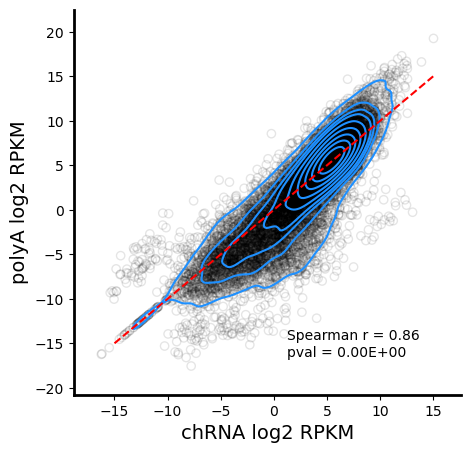

In [6]:
figdir = '/project2/yangili1/carlos_and_ben_shared/rough_figs/SupplementaryNoteFigure/'

kwargs = {'facecolor':'none', 'edgecolor':'black', 'alpha':0.1}

fig, ax = plt.subplots(figsize=(5, 5))

plot_correlation(chRNA_log2RPKM.loc[genes_idx].median(axis=1),
                 polyA_log2RPKM.loc[genes_idx].median(axis=1),
                 contour_color='dodgerblue', ylabel='polyA log2 RPKM', #title='chRNA',
                 xlabel='chRNA log2 RPKM', ax=ax, xy=(0.55, 0.1), **kwargs)

# plt.plot([-15, 12], [-5, -5], 'r--')
# plt.plot([-5, -5], [-15, 12], 'r--')
ax.plot([-15, 15], [-15, 15], 'r--')
ax.spines['left'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.savefig(figdir + 'Fig1_chRNA_polyA_expression.png', bbox_inches='tight', dpi=300)

In [7]:
# Get genes with protein coding junctions, NMD junctions, and within the 14000 genes
# for which we have RPKM

genes_pc_nmd = chRNA_juncs_NMD.index.intersection(chRNA_juncs_protein_coding.index)
genes_idx = genes_pc_nmd.intersection(genes_idx)#genes_pc_nmd.intersection(gene_len.index)

# For those genes, her NMD/(NMD + PC) junctions ratio

chRNA_juncs_NMD_ratio = chRNA_juncs_NMD.loc[genes_idx].divide(
    chRNA_juncs_NMD.loc[genes_idx] + chRNA_juncs_protein_coding.loc[genes_idx]
)

# RPKM is stored as log. To make it more interpretable, let's make it log2
chRNA_log2RPKM = all_RPKM.loc[genes_idx, chRNA_samples]*np.log2(np.e)
ml30_log2RPKM = all_RPKM.loc[genes_idx, ml30_samples]*np.log2(np.e)
ml60_log2RPKM = all_RPKM.loc[genes_idx, ml60_samples]*np.log2(np.e)
polyA_log2RPKM = all_RPKM.loc[genes_idx, polyA_samples]*np.log2(np.e)

chRNA_log2RPKM.columns = [x.split('.')[1] for x in chRNA_log2RPKM.columns]
polyA_log2RPKM.columns = [x.split('.')[1] for x in polyA_log2RPKM.columns]
ml30_log2RPKM.columns = [x.split('.')[1] for x in ml30_log2RPKM.columns]
ml60_log2RPKM.columns = [x.split('.')[1] for x in ml60_log2RPKM.columns]

chRNA_polyA_log2_difference = chRNA_log2RPKM - polyA_log2RPKM
ml30_polyA_log2_difference = ml30_log2RPKM - polyA_log2RPKM
chRNA_ml30_log2_difference = chRNA_log2RPKM - ml30_log2RPKM

Our previous analysis has raised concerns that there might be a length bias in polyA data. This is also observed in 4sU data, but not in chRNA.

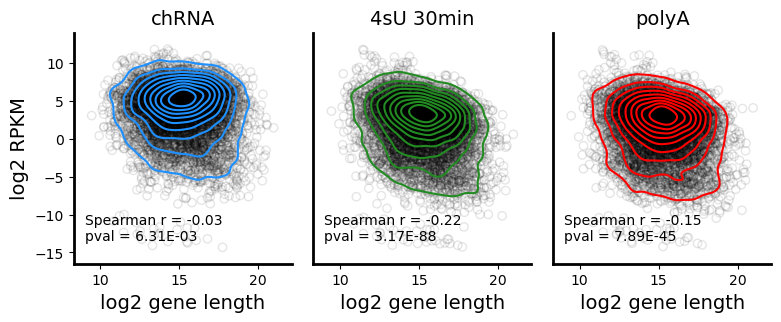

In [8]:
fig, ax = plt.subplots(nrows=1, ncols=3,  gridspec_kw={'wspace': 0.1}, figsize=(9, 3))

plot_correlation(np.log2(gene_len.loc[genes_idx]), chRNA_log2RPKM.median(axis=1), 
                 contour_color='dodgerblue', ylabel='log2 RPKM', title='chRNA',
                 xlabel='log2 gene length', ax=ax[0], **kwargs)

plot_correlation(np.log2(gene_len.loc[genes_idx]), ml30_log2RPKM.median(axis=1), 
                 contour_color='forestgreen', title='4sU 30min', 
                 xlabel='log2 gene length', ax=ax[1], **kwargs)

plot_correlation(np.log2(gene_len.loc[genes_idx]), polyA_log2RPKM.median(axis=1), 
                 contour_color='red', title='polyA', 
                 xlabel='log2 gene length', ax=ax[2], **kwargs)

for x in ax:
    x.spines['left'].set_linewidth(2)
    x.spines['bottom'].set_linewidth(2)
    x.spines['right'].set_visible(False)
    x.spines['top'].set_visible(False)
    
ax[1].set_yticks([])
ax[2].set_yticks([])

plt.savefig(figdir + 'Fig2A_gene_expression.png', bbox_inches='tight', dpi=300)

A small fraction of this variance could be that longer introns tend to be more likely to produce NMD isoforms. However, we expect this correlation to be weak, so it's possible that it is a sequencing bias. I suspect this specially because the correlation is even stronger for 4sU, which would make little sense if it was mostly due to NMD. So we want to be careful when trying to get the contribution of NMD to the variance.

Now let's check the correlation with NMD directly.

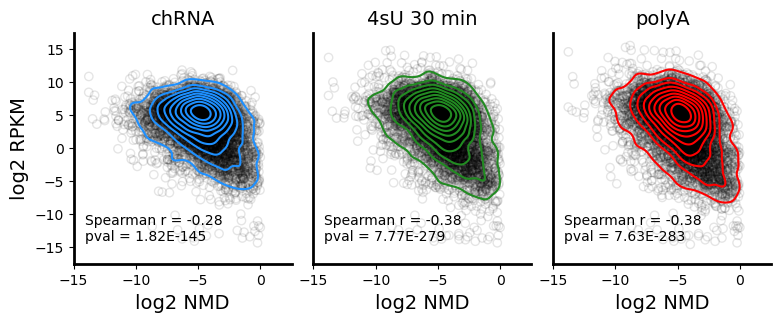

In [9]:
# Some plot kwargs to avoid repetition

fig, ax = plt.subplots(nrows=1, ncols=3,  gridspec_kw={'wspace': 0.1}, figsize=(9, 3))

plot_correlation(np.log2(chRNA_juncs_NMD_ratio.loc[genes_idx].mean(axis=1)), chRNA_log2RPKM.median(axis=1), 
                 contour_color='dodgerblue', ylabel='log2 RPKM', title='chRNA', 
                 xlabel='log2 NMD', ax=ax[0], **kwargs)

plot_correlation(np.log2(chRNA_juncs_NMD_ratio.loc[genes_idx].mean(axis=1)), ml30_log2RPKM.median(axis=1), 
                 contour_color='forestgreen', title='4sU 30 min', 
                 xlabel='log2 NMD', ax=ax[1], **kwargs)

plot_correlation(np.log2(chRNA_juncs_NMD_ratio.loc[genes_idx].mean(axis=1)), polyA_log2RPKM.median(axis=1), 
                 contour_color='red', title = 'polyA',
                 xlabel='log2 NMD', ax=ax[2], **kwargs)

for x in ax:
    x.set_xlim([-15, 2.5])
    x.set_ylim([-17.5, 17.5])
    x.spines['left'].set_linewidth(2)
    x.spines['bottom'].set_linewidth(2)
    x.spines['right'].set_visible(False)
    x.spines['top'].set_visible(False)
    
ax[1].set_yticks([])
ax[2].set_yticks([])

plt.savefig(figdir + 'Fig2B_NMD_expression.png', bbox_inches='tight', dpi=300)

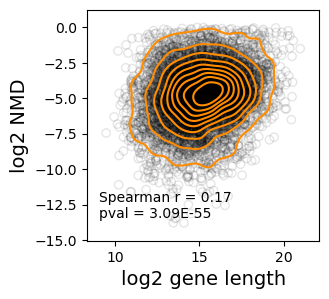

In [10]:
fig, ax = plt.subplots(figsize=(3, 3))

plot_correlation(np.log2(gene_len.loc[genes_idx]), 
                 np.log2(chRNA_juncs_NMD_ratio.loc[genes_idx].mean(axis=1)),
                 contour_color='darkorange', ylabel='log2 NMD', 
                 xlabel='log2 gene length', ax=ax, **kwargs)

plt.savefig(figdir + 'Fig2C_gene_NMD.png', bbox_inches='tight', dpi=300)

The correlation between NMD and expression is strong in all assays. This is probably because less expressed genes tend to produce more NMD isoforms. However, the correlation is stronger in polyA and weaker in chRNA. This might be due to the association between NMD and gene length (which is in turn correlated with coding region length). But a fraction of it could be actually the effects of NMD.

# NMD effects on RPKM differences

I will straitify the genes into quartiles according to the length of the coding region. Then I will observe the effects of NMD within each quartile. 

In [11]:
# First we separate the genes into length quartiles
genes_pc_nmd_len = gene_len.loc[genes_idx]
len_Q1, len_Q2, len_Q3, len_Q4 = get_series_quantile(genes_pc_nmd_len, quant=4)

# Next, for each quartile we separate the genes into NMD quintiles

NMD_ratio_quant_lenQ1_genes = get_series_quantile(chRNA_juncs_NMD_ratio.mean(axis=1), len_Q1, quant=5)
NMD_ratio_quant_lenQ2_genes = get_series_quantile(chRNA_juncs_NMD_ratio.mean(axis=1), len_Q2, quant=5)
NMD_ratio_quant_lenQ3_genes = get_series_quantile(chRNA_juncs_NMD_ratio.mean(axis=1), len_Q3, quant=5)
NMD_ratio_quant_lenQ4_genes = get_series_quantile(chRNA_juncs_NMD_ratio.mean(axis=1), len_Q4, quant=5)

quartile_list = [NMD_ratio_quant_lenQ1_genes,
                 NMD_ratio_quant_lenQ2_genes,
                 NMD_ratio_quant_lenQ3_genes,
                 NMD_ratio_quant_lenQ4_genes]


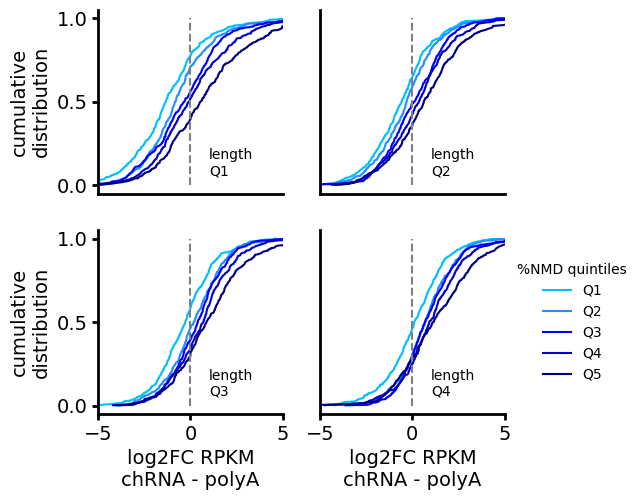

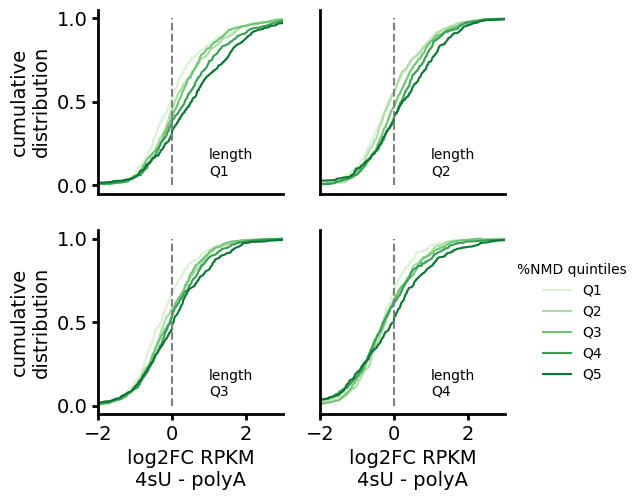

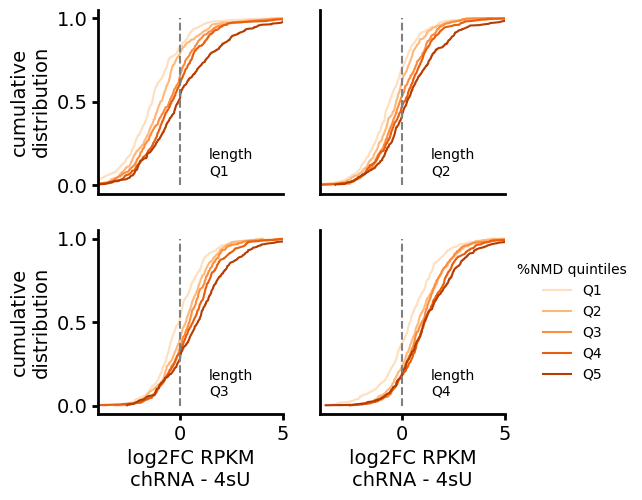

In [12]:
multiplot_quartiles(chRNA_polyA_log2_difference, quartile_list, 
                    ['deepskyblue', 'dodgerblue', 'blue', 'mediumblue', 'navy'],
                    xlabel = 'log2FC RPKM\nchRNA - polyA', 
                    legend_title = '%NMD quintiles',
                    savefig=figdir + 'Fig3A_chRNA_polyA_NMD.png')

# multiplot_quartiles(chRNA_polyA_log2_difference, quartile_list, 
#                     ['deepskyblue', 'dodgerblue', 'blue', 'mediumblue', 'navy'],
#                     xlabel = 'log2FC RPKM\nchRNA - polyA', 
#                     legend_title = '%NMD quintiles',
#                     savefig=figdir + 'Fig3A_chRNA_polyA_NMD.png', flat=True)

multiplot_quartiles(ml30_polyA_log2_difference, quartile_list, 
                    sns.color_palette("Greens", 5),
                   xlabel = 'log2FC RPKM\n4sU - polyA', xlim=[-2,3], legend_title = '%NMD quintiles',
                   savefig=figdir + 'Fig3B_4sU_polyA_NMD.png')

multiplot_quartiles(chRNA_ml30_log2_difference, quartile_list, 
                    sns.color_palette("Oranges", 5),
                   xlabel = 'log2FC RPKM\nchRNA - 4sU', xlim=[-4,5], legend_title = '%NMD quintiles',
                   savefig=figdir + 'Fig3C_chRNA_4sU_NMD.png')

In [13]:
# We get H3K36ME3 coverage over the gene body
h3k36me3_RPKM_ = pd.read_csv(
    '../code/QTLs/QTLTools/H3K36ME3/OnlyFirstRepsUnstandardized.qqnorm.bed.gz', sep='\t',
                   index_col=3)

h3k36me3_logRPKM = h3k36me3_RPKM_[h3k36me3_RPKM_.columns.intersection(polyA_log2RPKM.columns)]

# Get log2 fold difference
h3k36me3_log2RPKM = h3k36me3_logRPKM.loc[genes_idx]*np.log(np.e)
h3k36me3_polyA_log2_difference = h3k36me3_log2RPKM - polyA_log2RPKM


# For H3K4ME3, it's a bit trickier. We get the CPM of the peaks that are close (within 2000 bp) of
# a TSS for each gene

H3K4ME3_TSS = pd.read_csv('../code/featureCounts/H3K4ME3/Counts.txt',
                                 sep='\t', skiprows = 1)
H3K4ME3_names = [x.split('ME3/')[1].split('.1')[0] for x in H3K4ME3_TSS.columns if ('Alignments' in x)]

H3K4ME3 = pd.read_csv('../code/QTLs/QTLTools/H3K4ME3/CountsPeaksAtTSS.bed.gz',#'../../H3K4ME3.TSS.PeakCounts.bed.gz', 
                      sep='\t',
                     names = ['chrom', 'start', 'end', 'transcript_id', 'ensembl_id', 'strand',
                             'gene_id', 'chrom_', 'start_', 'end_', 'peak_id', 'peak_len',
                             'strand_'] + H3K4ME3_names + ['overlap_len'])
                     
H3K4ME3_samples = H3K4ME3.columns.intersection(chRNA_log2RPKM.columns)
H3K4ME3 = H3K4ME3.groupby(['ensembl_id', 'peak_id']).max()
H3K4ME3_counts = H3K4ME3.groupby('ensembl_id')[H3K4ME3_samples].sum()
h3k4me3_CPM = H3K4ME3_counts.divide(H3K4ME3_counts.sum(axis=0), axis=1)*1e6

h3k4me3_CPM = h3k4me3_CPM.loc[h3k4me3_CPM.median(axis=1) > 0]

h3k4me3_idx = genes_idx.intersection(h3k4me3_CPM.index)
h3k4me3_log2RPKM = np.log2(h3k4me3_CPM.loc[h3k4me3_idx]) 
h3k4me3_log2RPKM = h3k4me3_log2RPKM.loc[h3k4me3_log2RPKM.median(axis=1) > -1e100]
h3k4me3_idx = h3k4me3_log2RPKM.index
h3k4me3_polyA_log2_difference = h3k4me3_log2RPKM - polyA_log2RPKM.loc[h3k4me3_idx]

H3K27AC_TSS = pd.read_csv('../code/featureCounts/H3K27AC/Counts.txt',
                                 sep='\t', skiprows = 1)
H3K27AC_names = [x.split('27AC/')[1].split('.1')[0] for x in H3K27AC_TSS.columns if ('Alignments' in x)]

H3K27AC = pd.read_csv('../code/QTLs/QTLTools/H3K27AC/CountsPeaksAtTSS.bed.gz',#'../../H3K27AC.TSS.PeakCounts.bed.gz', 
                      sep='\t',
                     names = ['chrom', 'start', 'end', 'transcript_id', 'ensembl_id', 'strand',
                             'gene_id', 'chrom_', 'start_', 'end_', 'peak_id', 'peak_len',
                             'strand_'] + H3K27AC_names + ['overlap_len'])
                     
H3K27AC_samples = H3K27AC.columns.intersection(chRNA_log2RPKM.columns)
H3K27AC = H3K27AC.groupby(['ensembl_id', 'peak_id']).max()
H3K27AC_counts = H3K27AC.groupby('ensembl_id')[H3K27AC_samples].sum()
h3k27ac_CPM = H3K27AC_counts.divide(H3K27AC_counts.sum(axis=0), axis=1)*1e6

h3k27ac_CPM = h3k27ac_CPM.loc[h3k27ac_CPM.median(axis=1) > 0]

h3k27ac_idx = genes_idx.intersection(h3k27ac_CPM.index)
h3k27ac_log2RPKM = np.log2(h3k27ac_CPM.loc[h3k27ac_idx]) 
h3k27ac_log2RPKM = h3k27ac_log2RPKM.loc[h3k27ac_log2RPKM.median(axis=1) > -1e100]
h3k27ac_idx = h3k27ac_log2RPKM.index
h3k27ac_polyA_log2_difference = h3k27ac_log2RPKM - polyA_log2RPKM.loc[h3k27ac_idx]

Text(0.5, 0, '')

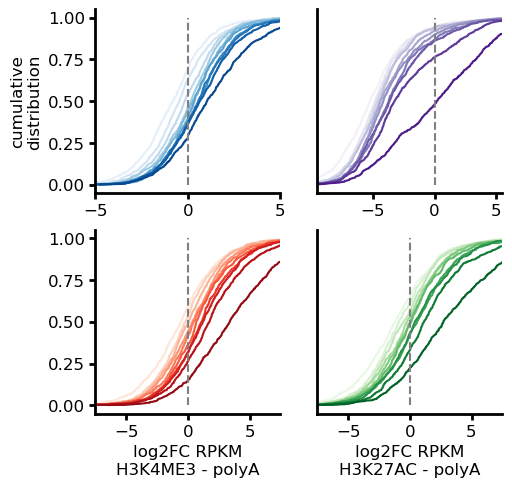

In [14]:
# like H3K27ac-polyA
# H3K4me3-polyA
# H3K36me3-polyA

figsize = (5.25,5.25)
fig, ax = plt.subplots(nrows=2, ncols=2, gridspec_kw={'height_ratios': [1, 1,]}, figsize=figsize)
    
NMD_ratio_quant_all_genes = get_series_quantile(chRNA_juncs_NMD_ratio.mean(axis=1), quant=10)
NMD_ratio_quant_all_h3k4me3 = get_series_quantile(chRNA_juncs_NMD_ratio.loc[h3k4me3_idx].mean(axis=1), quant=10)
NMD_ratio_quant_all_h3k27ac = get_series_quantile(chRNA_juncs_NMD_ratio.loc[h3k27ac_idx].mean(axis=1), quant=10)



plot_cumulative_quantiles(chRNA_polyA_log2_difference, NMD_ratio_quant_all_genes, 
                          sns.color_palette("Blues", 10),
#                                    ['deepskyblue', 'dodgerblue', 'blue', 'mediumblue', 'navy'], 
                                   ax=ax[0,0],
                                   ylabel='cumulative\ndistribution',
                                   xlabel='log2FC RPKM\nchRNA - polyA',
                                   legend_title = '%NMD quintiles',
                                   vertical_line_at = 0, xlim=[-5, 5],
                                   fontsize=12)

plot_cumulative_quantiles(h3k36me3_polyA_log2_difference, NMD_ratio_quant_all_genes, 
                    sns.color_palette("Purples", 10), xlim=[-9.5,5.5], ax=ax[0,1],
                          vertical_line_at = 0,
                   xlabel = 'log2FC RPKM\nH3K36ME3 - polyA', legend_title = '%NMD quintiles', fontsize=12)

plot_cumulative_quantiles(h3k4me3_polyA_log2_difference, NMD_ratio_quant_all_h3k4me3, 
                    sns.color_palette("Reds", 10), xlim=[-7.5,7.5], ax=ax[1,0],
                          vertical_line_at = 0,
                   xlabel = 'log2FC RPKM\nH3K4ME3 - polyA', legend_title = '%NMD quintiles', fontsize=12)

plot_cumulative_quantiles(h3k27ac_polyA_log2_difference, NMD_ratio_quant_all_h3k27ac, 
                    sns.color_palette("Greens", 10), xlim=[-7.5,7.5], ax=ax[1,1],
                          vertical_line_at = 0,
                   xlabel = 'log2FC RPKM\nH3K27AC - polyA', legend_title = '%NMD quintiles', fontsize=12)

ax[0,1].set_yticks([])
ax[1,1].set_yticks([])

ax[0,0].set_xlabel('')
ax[0,1].set_xlabel('')

Text(0.5, 0, '')

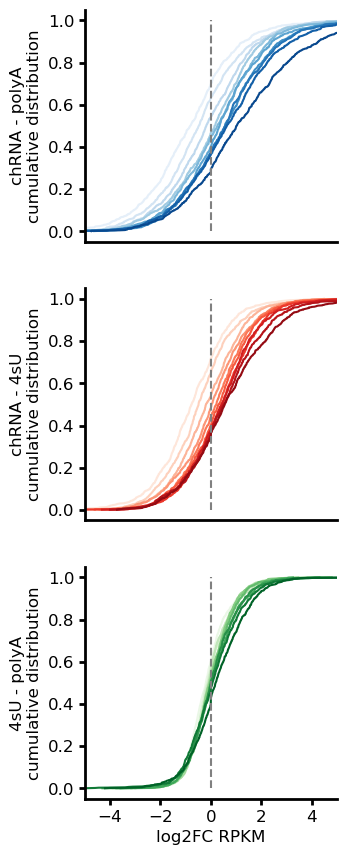

In [15]:
# like H3K27ac-polyA
# H3K4me3-polyA
# H3K36me3-polyA

figsize = (3.25, 10.25)
fig, ax = plt.subplots(nrows=3, ncols=1, gridspec_kw={'hspace': 0.2}, figsize=figsize)
    
NMD_ratio_quant_all_genes = get_series_quantile(chRNA_juncs_NMD_ratio.mean(axis=1), quant=10)
NMD_ratio_quant_all_h3k4me3 = get_series_quantile(chRNA_juncs_NMD_ratio.loc[h3k4me3_idx].mean(axis=1), quant=10)
NMD_ratio_quant_all_h3k27ac = get_series_quantile(chRNA_juncs_NMD_ratio.loc[h3k27ac_idx].mean(axis=1), quant=10)



plot_cumulative_quantiles(chRNA_polyA_log2_difference, NMD_ratio_quant_all_genes, 
                          sns.color_palette("Blues", 10),
#                                    ['deepskyblue', 'dodgerblue', 'blue', 'mediumblue', 'navy'], 
                                   ax=ax[0],
                                   ylabel='chRNA - polyA\ncumulative distribution',
                                   xlabel='log2FC RPKM\nchRNA - polyA',
                                   legend_title = '%NMD quintiles',
                                   vertical_line_at = 0, xlim=[-5, 5],
                                   fontsize=12)

plot_cumulative_quantiles(chRNA_ml30_log2_difference, NMD_ratio_quant_all_h3k4me3, 
#                           ['deepskyblue', 'dodgerblue', 'blue', 'mediumblue', 'navy'], 
                          
                    sns.color_palette("Reds", 10), 
                          xlim=[-5, 5], ax=ax[1],
                          vertical_line_at = 0,
                          ylabel='chRNA - 4sU\ncumulative distribution',
                   xlabel = 'log2FC RPKM\nchRNA - 4sU', legend_title = '%NMD quintiles', fontsize=12)

plot_cumulative_quantiles(ml30_polyA_log2_difference, NMD_ratio_quant_all_genes, 
#                           ['deepskyblue', 'dodgerblue', 'blue', 'mediumblue', 'navy'],
                          
                    sns.color_palette("Greens", 10), 
                          xlim=[-5, 5], ax=ax[2],
                          vertical_line_at = 0, plot_legend=False,
                          ylabel='4sU - polyA\ncumulative distribution',
                   xlabel = 'log2FC RPKM', fontsize=12, label_list = [None, None, None, None, None,
                                                                     None, None, None, None, None])



ax[0].set_xticks([])
ax[1].set_xticks([])

ax[0].set_xlabel('')
ax[1].set_xlabel('')

# color_list = sns.color_palette("Greys", 5)
# for i in range(5):
#     ax[2].plot([-50], [0.5], c = color_list[i], label = 'Q' + str(i+1))

# ax[2].legend(title = 'NMD quintiles', frameon=False, 
#                           loc='center left', bbox_to_anchor=(1, 0.5))

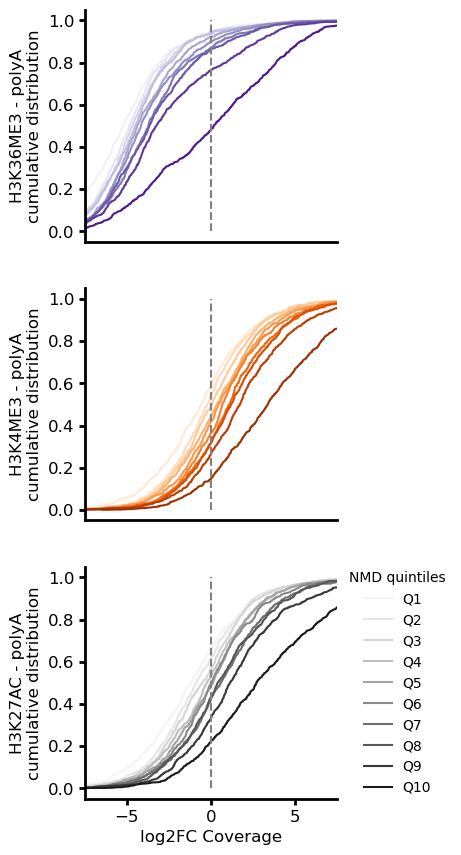

In [16]:

figsize = (3.25, 10.25)
fig, ax = plt.subplots(nrows=3, ncols=1, gridspec_kw={'hspace': 0.2}, figsize=figsize)

plot_cumulative_quantiles(h3k36me3_polyA_log2_difference, NMD_ratio_quant_all_genes, 
                    sns.color_palette("Purples", 10), xlim=[-7.5,7.5], ax=ax[0],
                          vertical_line_at = 0,
                           ylabel='H3K36ME3 - polyA\ncumulative distribution',
                   xlabel = 'log2FC RPKM\nH3K36ME3 - polyA', legend_title = '%NMD quintiles', fontsize=12)

plot_cumulative_quantiles(h3k4me3_polyA_log2_difference, NMD_ratio_quant_all_h3k4me3, 
                    sns.color_palette("Oranges", 10), xlim=[-7.5,7.5], ax=ax[1],
                          vertical_line_at = 0,
                           ylabel='H3K4ME3 - polyA\ncumulative distribution',
                   xlabel = 'log2FC RPKM\nH3K4ME3 - polyA', legend_title = '%NMD quintiles', fontsize=12)

plot_cumulative_quantiles(h3k27ac_polyA_log2_difference, NMD_ratio_quant_all_h3k27ac, 
                    sns.color_palette("Greys", 10), xlim=[-7.5,7.5], ax=ax[2],
                          vertical_line_at = 0,
                          ylabel='H3K27AC - polyA\ncumulative distribution',
                   xlabel = 'log2FC Coverage', legend_title = '%NMD quintiles', fontsize=12,
                         label_list = [None, None, None, None, None, None, None, None, None, None])


ax[0].set_xticks([])
ax[1].set_xticks([])

ax[0].set_xlabel('')
ax[1].set_xlabel('')

color_list = sns.color_palette("Greys", 10)
for i in range(10):
    ax[2].plot([-50], [0.5], c = color_list[i], label = 'Q' + str(i+1))

ax[2].legend(title = 'NMD quintiles', frameon=False, 
                          loc='center left', bbox_to_anchor=(1, 0.5))

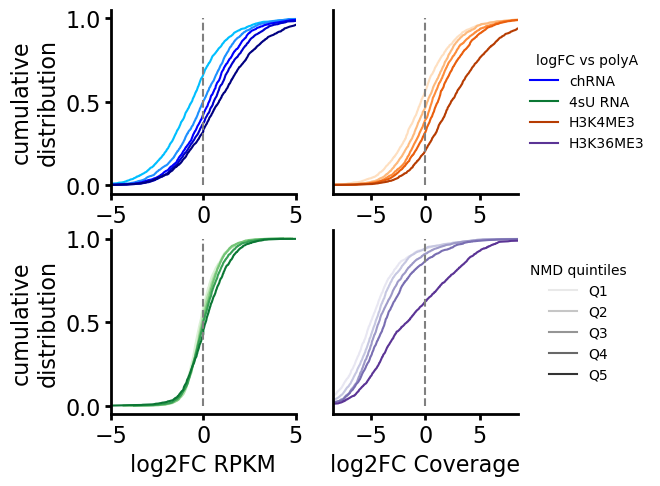

In [18]:
# chRNA vs polyA, K4ME3 vs polyA, and K36ME3 vs polyA; 4sU vs polyA


figsize = (5.25, 5.25)
fig, ax = plt.subplots(nrows=2, ncols=2, gridspec_kw={'hspace': 0.2}, figsize=figsize)

    
NMD_ratio_quant_all_genes = get_series_quantile(chRNA_juncs_NMD_ratio.mean(axis=1), quant=5)
NMD_ratio_quant_all_h3k4me3 = get_series_quantile(chRNA_juncs_NMD_ratio.loc[h3k4me3_idx].mean(axis=1), quant=5)
NMD_ratio_quant_all_h3k27ac = get_series_quantile(chRNA_juncs_NMD_ratio.loc[h3k27ac_idx].mean(axis=1), quant=5)



plot_cumulative_quantiles(chRNA_polyA_log2_difference, NMD_ratio_quant_all_genes, 
#                           sns.color_palette("Blues", 10),
                                   ['deepskyblue', 'dodgerblue', 'blue', 'mediumblue', 'navy'], 
                                   ax=ax[0, 0],
                                   ylabel='cumulative\ndistribution',
                                   xlabel='log2FC RPKM\nchRNA - polyA',
                                   legend_title = '%NMD quintiles',
                                   vertical_line_at = 0, xlim=[-5, 5],
                                   fontsize=16)

plot_cumulative_quantiles(ml30_polyA_log2_difference, NMD_ratio_quant_all_genes, 
                    sns.color_palette("Greens", 5), xlim=[-5, 5], ax=ax[1, 0],
                          ylabel='cumulative\ndistribution',
                          vertical_line_at = 0,
#                            ylabel='4sU RNA - polyA\ncumulative distribution',
                   xlabel = 'log2FC RPKM', legend_title = '%NMD quintiles', fontsize=16,
                         label_list = [None, None, None, None, None])

plot_cumulative_quantiles(h3k4me3_polyA_log2_difference, NMD_ratio_quant_all_h3k4me3, 
                    sns.color_palette("Oranges", 5), xlim=[-8.5,8.5], ax=ax[0, 1],
                          vertical_line_at = 0,
                           label_list = [None, None, None, None, None],
                   xlabel = 'log2FC RPKM', legend_title = '%NMD quintiles', fontsize=16)

plot_cumulative_quantiles(h3k36me3_polyA_log2_difference, NMD_ratio_quant_all_genes, 
                    sns.color_palette("Purples", 5), xlim=[-8.5,8.5], ax=ax[1, 1],
                          vertical_line_at = 0,
#                           ylabel='H3K36ME3 - polyA\ncumulative distribution',
                   xlabel = 'log2FC Coverage', legend_title = '%NMD quintiles', fontsize=16,
                         label_list = [None, None, None, None, None])

ax[0,1].set_yticks([])
ax[1,1].set_yticks([])
ax[0,1].set_xlabel("")
ax[0,0].set_xlabel("")

ax[0,1].plot([-50], [0.5], c = 'blue', label = 'chRNA')
ax[0,1].plot([-50], [0.5], c = sns.color_palette("Greens", 5)[4], label = '4sU RNA')
ax[0,1].plot([-50], [0.5], c = sns.color_palette("Oranges", 5)[4], label = 'H3K4ME3')
ax[0,1].plot([-50], [0.5], c = sns.color_palette("Purples", 5)[4], label = 'H3K36ME3')

ax[0,1].legend(title = 'logFC vs polyA', frameon=False, 
                          loc='center left', bbox_to_anchor=(1, 0.5))

color_list = sns.color_palette("Greys", 5)
for i in range(5):
    ax[1,1].plot([-50], [0.5], c = color_list[i], label = 'Q' + str(i+1))

ax[1,1].legend(title = 'NMD quintiles', frameon=False, 
                          loc='center left', bbox_to_anchor=(1, 0.5))

plt.savefig('../code/plots/Fig1.coverage_distribution.pdf', dpi=300, bbox_inches='tight',)
plt.savefig('../code/plots/Fig1.coverage_distribution.png', dpi=300, bbox_inches='tight',)

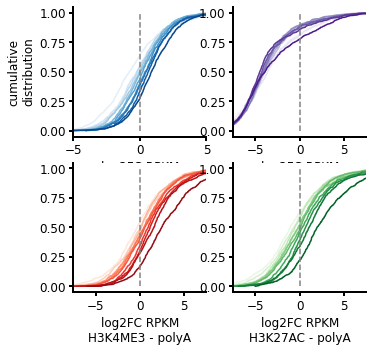

In [47]:
len_quant_all_genes = get_series_quantile(genes_pc_nmd_len, quant=10)
len_quant_h3k4me3 = get_series_quantile(genes_pc_nmd_len.loc[h3k4me3_idx], quant=10)
len_quant_h3k27ac = get_series_quantile(genes_pc_nmd_len.loc[h3k27ac_idx], quant=10)

figsize = (5.25,5.25)
fig, ax = plt.subplots(nrows=2, ncols=2, gridspec_kw={'height_ratios': [1, 1,]}, figsize=figsize)
  

plot_cumulative_quantiles(chRNA_polyA_log2_difference, len_quant_all_genes, 
                          sns.color_palette("Blues", 10),
#                                    ['deepskyblue', 'dodgerblue', 'blue', 'mediumblue', 'navy'], 
                                   ax=ax[0,0],
                                   ylabel='cumulative\ndistribution',
                                   xlabel='log2FC RPKM\nchRNA - polyA',
                                   legend_title = '%NMD quintiles',
                                   vertical_line_at = 0, xlim=[-5, 5],
                                   fontsize=12)

plot_cumulative_quantiles(h3k36me3_polyA_log2_difference, len_quant_all_genes, 
                    sns.color_palette("Purples", 10), xlim=[-7.5,7.5], ax=ax[0,1],
                          vertical_line_at = 0,
                   xlabel = 'log2FC RPKM\nH3K36ME3 - polyA', legend_title = '%NMD quintiles', fontsize=12)

plot_cumulative_quantiles(h3k4me3_polyA_log2_difference, len_quant_h3k4me3, 
                    sns.color_palette("Reds", 10), xlim=[-7.5,7.5], ax=ax[1,0],
                          vertical_line_at = 0,
                   xlabel = 'log2FC RPKM\nH3K4ME3 - polyA', legend_title = '%NMD quintiles', fontsize=12)

plot_cumulative_quantiles(h3k27ac_polyA_log2_difference, len_quant_h3k27ac, 
                    sns.color_palette("Greens", 10), xlim=[-7.5,7.5], ax=ax[1,1],
                          vertical_line_at = 0,
                   xlabel = 'log2FC RPKM\nH3K27AC - polyA', legend_title = '%NMD quintiles', fontsize=12)


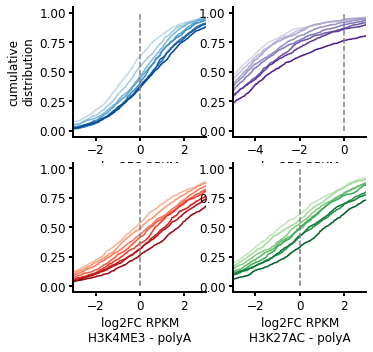

In [42]:
# like H3K27ac-polyA
# H3K4me3-polyA
# H3K36me3-polyA

figsize = (5.25,5.25)
fig, ax = plt.subplots(nrows=2, ncols=2, gridspec_kw={'height_ratios': [1, 1,]}, figsize=figsize)
    
NMD_ratio_quant_all_genes = get_series_quantile(chRNA_juncs_NMD_ratio.mean(axis=1), quant=10)
NMD_ratio_quant_all_h3k4me3 = get_series_quantile(chRNA_juncs_NMD_ratio.loc[h3k4me3_idx].mean(axis=1), quant=10)
NMD_ratio_quant_all_h3k27ac = get_series_quantile(chRNA_juncs_NMD_ratio.loc[h3k27ac_idx].mean(axis=1), quant=10)


plot_cumulative_quantiles(chRNA_polyA_log2_difference, NMD_ratio_quant_all_genes[1:-1], 
                          sns.color_palette("Blues", 10)[2:],
#                                    ['deepskyblue', 'dodgerblue', 'blue', 'mediumblue', 'navy'], 
                                   ax=ax[0,0],
                                   ylabel='cumulative\ndistribution',
                                   xlabel='log2FC RPKM\nchRNA - polyA',
                                   legend_title = '%NMD quintiles',
                                   vertical_line_at = 0, xlim=[-3, 3],
                                   fontsize=12)

plot_cumulative_quantiles(h3k36me3_polyA_log2_difference, NMD_ratio_quant_all_genes[1:-1], 
                    sns.color_palette("Purples", 10)[2:], xlim=[-5, 1], ax=ax[0,1],
                          vertical_line_at = 0,
                   xlabel = 'log2FC RPKM\nH3K36ME3 - polyA', legend_title = '%NMD quintiles', fontsize=12)

plot_cumulative_quantiles(h3k4me3_polyA_log2_difference, NMD_ratio_quant_all_h3k4me3[1:-1], 
                    sns.color_palette("Reds", 10)[2:], xlim=[-3, 3], ax=ax[1,0],
                          vertical_line_at = 0,
                   xlabel = 'log2FC RPKM\nH3K4ME3 - polyA', legend_title = '%NMD quintiles', fontsize=12)

plot_cumulative_quantiles(h3k27ac_polyA_log2_difference, NMD_ratio_quant_all_h3k27ac[1:-1], 
                    sns.color_palette("Greens", 10)[2:], xlim=[-3, 3], ax=ax[1,1],
                          vertical_line_at = 0,
                   xlabel = 'log2FC RPKM\nH3K27AC - polyA', legend_title = '%NMD quintiles', fontsize=12)

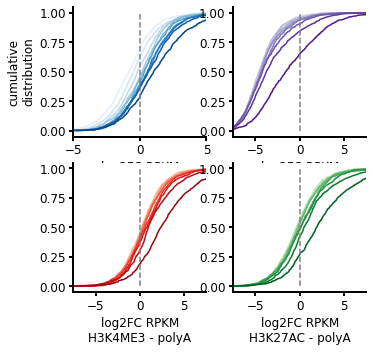

In [33]:
h3k4me3_chRNA_log2_difference = h3k4me3_log2RPKM - chRNA_log2RPKM.loc[h3k4me3_idx]
h3k36me3_chRNA_log2_difference = h3k36me3_log2RPKM - chRNA_log2RPKM
h3k27ac_chRNA_log2_difference = h3k27ac_log2RPKM - chRNA_log2RPKM.loc[h3k27ac_idx]


figsize = (5.25,5.25)
fig, ax = plt.subplots(nrows=2, ncols=2, gridspec_kw={'height_ratios': [1, 1,]}, figsize=figsize)
 
plot_cumulative_quantiles(chRNA_polyA_log2_difference, NMD_ratio_quant_all_genes, 
                                   sns.color_palette("Blues", 10),
#                                    ['deepskyblue', 'dodgerblue', 'blue', 'mediumblue', 'navy'], 
                                   ax=ax[0,0],
                                   ylabel='cumulative\ndistribution',
                                   xlabel='log2FC RPKM\nchRNA - polyA',
                                   legend_title = '%NMD quintiles',
                                   vertical_line_at = 0, xlim=[-5, 5],
                                   fontsize=12)

plot_cumulative_quantiles(h3k36me3_chRNA_log2_difference, NMD_ratio_quant_all_genes, 
                    sns.color_palette("Purples", 10), xlim=[-7.5,7.5], ax=ax[0,1],
                          vertical_line_at = 0,
                   xlabel = 'log2FC RPKM\nH3K36ME3 - polyA', legend_title = '%NMD quintiles', fontsize=12)

plot_cumulative_quantiles(h3k4me3_chRNA_log2_difference, NMD_ratio_quant_all_h3k4me3, 
                    sns.color_palette("Reds", 10), xlim=[-7.5,7.5], ax=ax[1,0],
                          vertical_line_at = 0,
                   xlabel = 'log2FC RPKM\nH3K4ME3 - polyA', legend_title = '%NMD quintiles', fontsize=12)

plot_cumulative_quantiles(h3k27ac_chRNA_log2_difference, NMD_ratio_quant_all_h3k27ac, 
                    sns.color_palette("Greens", 10), xlim=[-7.5,7.5], ax=ax[1,1],
                          vertical_line_at = 0,
                   xlabel = 'log2FC RPKM\nH3K27AC - polyA', legend_title = '%NMD quintiles', fontsize=12)

In [ ]:
h3k4me3_polyA_log2_difference = h3k4me3_log2RPKM - polyA_log2RPKM.loc[h3k4me3_idx]

This looks great. NMD clearly stratifies the log2 fold change between chRNA, 4sU and polyA in the way that we expect it: more NMD means more chRNA compared to both polyA and 4sU; and also more 4sU compared with polyA. 

Clearly length still plays a role in these differences, as it can be seen by the point in which the lines cross 0 at the different quartiles. It's reassuring that 4sU vs polyA still looks like we expected, despite the fact that 4sU seems to have the same or even stronger length bias than polyA. Let's corroborate by stratifying each quartile by length again instead of % NMD.

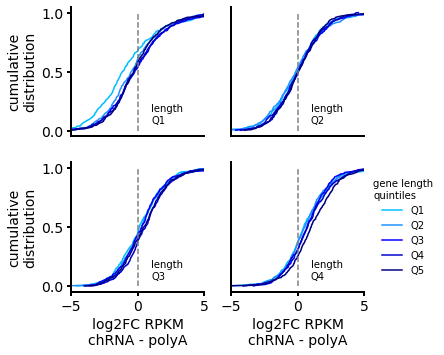

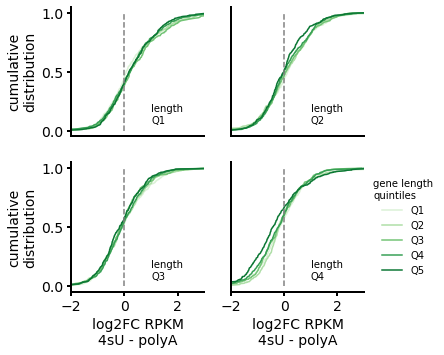

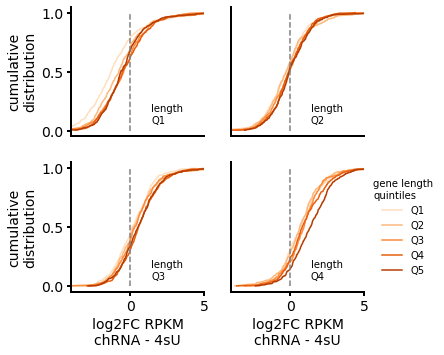

In [13]:
len_quint_lenQ1_genes = get_series_quantile(genes_pc_nmd_len, len_Q1, quant=5)
len_quint_lenQ2_genes = get_series_quantile(genes_pc_nmd_len, len_Q2, quant=5)
len_quint_lenQ3_genes = get_series_quantile(genes_pc_nmd_len, len_Q3, quant=5)
len_quint_lenQ4_genes = get_series_quantile(genes_pc_nmd_len, len_Q4, quant=5)

quartile_len_list = [len_quint_lenQ1_genes,
                     len_quint_lenQ2_genes,
                     len_quint_lenQ3_genes,
                     len_quint_lenQ4_genes]

multiplot_quartiles(chRNA_polyA_log2_difference, quartile_len_list, 
                    ['deepskyblue', 'dodgerblue', 'blue', 'mediumblue', 'navy'],
                   xlabel = 'log2FC RPKM\nchRNA - polyA', legend_title = 'gene length\nquintiles',
                   savefig=figdir + 'Fig4A_chRNA_4sU_length.png')

multiplot_quartiles(ml30_polyA_log2_difference, quartile_len_list, 
                    sns.color_palette("Greens", 5),
                   xlabel = 'log2FC RPKM\n4sU - polyA', xlim=[-2,3], 
                    legend_title = 'gene length\nquintiles',
                   savefig=figdir + 'Fig4B_chRNA_4sU_length.png')

multiplot_quartiles(chRNA_ml30_log2_difference, quartile_len_list, 
                    sns.color_palette("Oranges", 5),
                   xlabel = 'log2FC RPKM\nchRNA - 4sU', xlim=[-4,5], 
                    legend_title = 'gene length\nquintiles',
                   savefig=figdir + 'Fig4C_chRNA_4sU_length.png')

Great, it looks like length has a smaller effect within the quartiles, than % NMD does. Length even seems to have the opposite effect in 4sU vs polyA. This is reassuring.

Now we will repeat the experiment, but with histone modifications.

Plotting by %NMD quintiles...

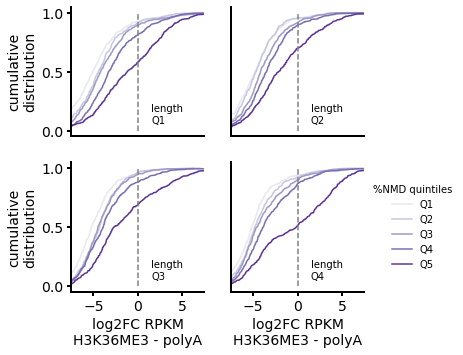

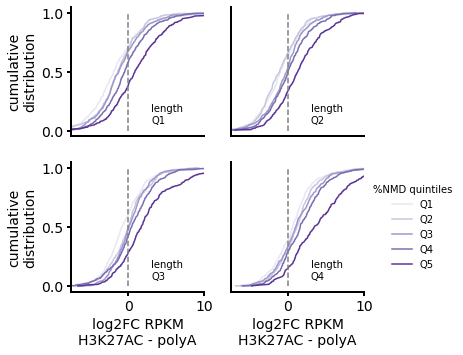

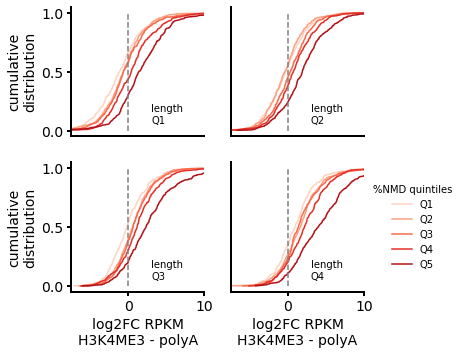

In [21]:
multiplot_quartiles(h3k36me3_polyA_log2_difference, quartile_list, 
                    sns.color_palette("Purples", 5), xlim=[-7.5,7.5],
                   xlabel = 'log2FC RPKM\nH3K36ME3 - polyA', legend_title = '%NMD quintiles',
                   savefig=figdir + 'Fig5A_H3K36ME3_polyA_NMD.png')

len_Q1h27, len_Q2h27, len_Q3h27, len_Q4h27 = get_series_quantile(genes_pc_nmd_len.loc[h3k27ac_idx], quant=4)
NMD_ratio_quant_lenQ1_genes_h27 = get_series_quantile(chRNA_juncs_NMD_ratio.mean(axis=1), len_Q1h27, quant=5)
NMD_ratio_quant_lenQ2_genes_h27 = get_series_quantile(chRNA_juncs_NMD_ratio.mean(axis=1), len_Q2h27, quant=5)
NMD_ratio_quant_lenQ3_genes_h27 = get_series_quantile(chRNA_juncs_NMD_ratio.mean(axis=1), len_Q3h27, quant=5)
NMD_ratio_quant_lenQ4_genes_h27 = get_series_quantile(chRNA_juncs_NMD_ratio.mean(axis=1), len_Q4h27, quant=5)

quartile_list_h27 = [NMD_ratio_quant_lenQ1_genes_h27,
                     NMD_ratio_quant_lenQ2_genes_h27,
                     NMD_ratio_quant_lenQ3_genes_h27,
                     NMD_ratio_quant_lenQ4_genes_h27]

multiplot_quartiles(h3k27ac_polyA_log2_difference, quartile_list_h27, 
                    sns.color_palette("Purples", 5),
                   xlabel = 'log2FC RPKM\nH3K27AC - polyA', xlim=[-7.5,10], 
                    legend_title = '%NMD quintiles',
                   savefig=figdir + 'Fig5B_H3K27AC_polyA_NMD.png')

len_Q1h4, len_Q2h4, len_Q3h4, len_Q4h4 = get_series_quantile(genes_pc_nmd_len.loc[h3k4me3_idx], quant=4)
NMD_ratio_quant_lenQ1_genes_h4 = get_series_quantile(chRNA_juncs_NMD_ratio.mean(axis=1), len_Q1h4, quant=5)
NMD_ratio_quant_lenQ2_genes_h4 = get_series_quantile(chRNA_juncs_NMD_ratio.mean(axis=1), len_Q2h4, quant=5)
NMD_ratio_quant_lenQ3_genes_h4 = get_series_quantile(chRNA_juncs_NMD_ratio.mean(axis=1), len_Q3h4, quant=5)
NMD_ratio_quant_lenQ4_genes_h4 = get_series_quantile(chRNA_juncs_NMD_ratio.mean(axis=1), len_Q4h4, quant=5)

quartile_list_h4 = [NMD_ratio_quant_lenQ1_genes_h4,
                     NMD_ratio_quant_lenQ2_genes_h4,
                     NMD_ratio_quant_lenQ3_genes_h4,
                     NMD_ratio_quant_lenQ4_genes_h4]

multiplot_quartiles(h3k4me3_polyA_log2_difference, quartile_list_h4, 
                    sns.color_palette("Reds", 5),
                   xlabel = 'log2FC RPKM\nH3K4ME3 - polyA', xlim=[-7.5,10], 
                    legend_title = '%NMD quintiles',
                   savefig=figdir + 'Fig5C_H3K4ME3_polyA_NMD.png')






And now by gene length quintiles...

In [22]:
multiplot_quartiles(h3k36me3_polyA_log2_difference, quartile_len_list, 
                    sns.color_palette("copper_r", 5), xlim=[-7.5,7.5],
                   xlabel = 'log2FC RPKM\nH3K36ME3 - polyA', legend_title = 'gene length quintiles',
                   savefig=figdir + 'Fig6A_H3K36ME3_polyA_length.png')



len_quint_lenQ1_genes_h27 = get_series_quantile(genes_pc_nmd_len, len_Q1h27, quant=5)
len_quint_lenQ2_genes_h27 = get_series_quantile(genes_pc_nmd_len, len_Q1h27, quant=5)
len_quint_lenQ3_genes_h27 = get_series_quantile(genes_pc_nmd_len, len_Q1h27, quant=5)
len_quint_lenQ4_genes_h27 = get_series_quantile(genes_pc_nmd_len, len_Q1h27, quant=5)

quartile_len_list_h27 = [len_quint_lenQ1_genes_h27,
                     len_quint_lenQ2_genes_h27,
                     len_quint_lenQ3_genes_h27,
                     len_quint_lenQ4_genes_h27]



multiplot_quartiles(h3k27ac_polyA_log2_difference, quartile_len_list_h27, 
                    sns.color_palette("Purples", 5),
                   xlabel = 'log2FC RPKM\nH3K27AC - polyA', xlim=[-7.5,10], 
                    legend_title = '%NMD quintiles',
                   savefig=figdir + 'Fig6B_H3K27AC_polyA_length.png')


len_quint_lenQ1_genes_h4 = get_series_quantile(genes_pc_nmd_len, len_Q1h4, quant=5)
len_quint_lenQ2_genes_h4 = get_series_quantile(genes_pc_nmd_len, len_Q1h4, quant=5)
len_quint_lenQ3_genes_h4 = get_series_quantile(genes_pc_nmd_len, len_Q1h4, quant=5)
len_quint_lenQ4_genes_h4 = get_series_quantile(genes_pc_nmd_len, len_Q1h4, quant=5)

quartile_len_list_h4 = [len_quint_lenQ1_genes_h4,
                     len_quint_lenQ2_genes_h4,
                     len_quint_lenQ3_genes_h4,
                     len_quint_lenQ4_genes_h4]



multiplot_quartiles(h3k4me3_polyA_log2_difference, quartile_len_list_h4, 
                    sns.color_palette("Reds", 5),
                   xlabel = 'log2FC RPKM\nH3K4ME3 - polyA', xlim=[-7.5,10], 
                    legend_title = '%NMD quintiles',
                   savefig=figdir + 'Fig6C_H3K4ME3_polyA_length.png')


NameError: name 'quartile_len_list' is not defined

Once again, the effect looks like we expected if NMD affects the expression of polyA. Histone marks have little to no association with splicing. So any effect that we see when we stratify by NMD should come from post-transcriptional RNA degradation, likely from NMD.

# Regression models to get percent of variance explained

Finally I will run some linear regression models to get the percent of the polyA expression variance that can be explained by NMD.

## polyA ~ chRNA + NMD + gene_length

Here I will do a linear regression of the log2 expression of polyA, using the log2 expression of chRNA as the independent variable. I will also use as independent variable the log2 of the % NMD, to see how much of the differences between chRNA and polyA come from NMD. I will also include the length of the CDS to account for the sequencing length bias that polyA seems to have.

For each gene, I will use the median expression across all the shared samples between assays. Pressumably I could run one regression per sample, and perhaps that would show some interesting results. But first I want to see if the simplest approach would work.

In [19]:
df = pd.DataFrame()
df['polyA'] = zscore(polyA_log2RPKM.loc[genes_idx].median(axis=1))
df['chRNA'] = zscore(chRNA_log2RPKM.loc[genes_idx].median(axis=1))
df['NMD'] = zscore(np.log2(chRNA_juncs_NMD_ratio.loc[genes_idx].mean(axis=1)))
df['ml30'] = zscore(ml30_log2RPKM.loc[genes_idx].median(axis=1))
df['H3K36ME3'] = zscore(h3k36me3_log2RPKM.loc[genes_idx].median(axis=1))
df['gene_length'] = zscore(np.log2(gene_len.loc[genes_idx]))

model, r2 = run_regression(df, ['chRNA', 'NMD', 'gene_length'], 'polyA', robust = False)

print(get_var_explained(model.params, r2))


{'chRNA': 0.7546122686136386, 'NMD': 0.01856154208083268, 'gene_length': 0.007495717596712183}


Naturally it looks like most variance in polyA expression is explained by chRNA expression, with just a modest amount from NMD (1.8%) and gene length (0.7%). It's good to see that NMD seems to contribute more than gene length. 

## (Residual polyA ~ chRNA) ~ NMD + gene_length

Now let's see what happens if I regress polyA ~ chRNA + error, and I look at the contribution of NMD and gene length to the residual.

In [20]:
model, r2 = run_regression(df, ['chRNA'], 'polyA')

df['residuals'] = zscore(model.resid)

model2, r22 = run_regression(df, ['NMD', 'gene_length'], 'residuals')

var = get_var_explained(model2.params, r22)
print(var)

{'NMD': 0.06200173208800077, 'gene_length': 0.03189335421402271}


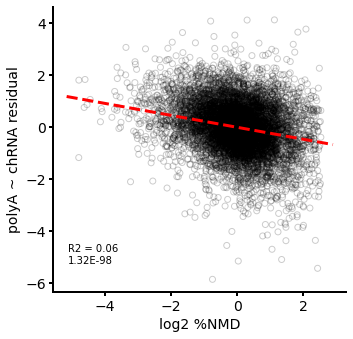

In [21]:
plot_regression(df.NMD, df.residuals, model2.params.loc['NMD'], var['NMD'], 
                model2.pvalues.loc['NMD'], xlabel='log2 %NMD', 
                ylabel='polyA ~ chRNA residual')

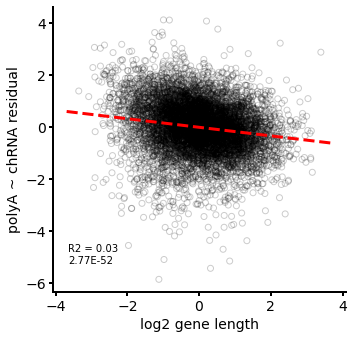

In [22]:
plot_regression(df.gene_length, df.residuals, model2.params.loc['gene_length'], var['gene_length'], 
                model2.pvalues.loc['gene_length'], xlabel='log2 gene length', 
                ylabel='polyA ~ chRNA residual')

## polyA ~ chRNA + NMD + gene_length, stratified by length
Previously we observed that we can observe NMD effects at different quartiles of gene length. Now let's see how the regression looks like when we stratified by length quartiles. I'm just testing the first two quartiles.

#### First quartile

In [ ]:
df = pd.DataFrame()
df['polyA'] = zscore(polyA_log2RPKM.loc[len_Q1].median(axis=1))
df['chRNA'] = zscore(chRNA_log2RPKM.loc[len_Q1].median(axis=1))
df['NMD'] = zscore(np.log2(chRNA_juncs_NMD_ratio.loc[len_Q1].mean(axis=1)))
df['ml30'] = zscore(ml30_log2RPKM.loc[len_Q1].median(axis=1))
df['H3K36ME3'] = zscore(h3k36me3_log2RPKM.loc[len_Q1].median(axis=1))
df['gene_length'] = zscore(np.log2(gene_len.loc[len_Q1]))

model, r2 = run_regression(df, ['chRNA', 'NMD', 'gene_length'], 'polyA', robust = False)

print(get_var_explained(model.params, r2))



In [ ]:
model, r2 = run_regression(df, ['chRNA'], 'polyA')

df['residuals'] = zscore(model.resid)

model2, r22 = run_regression(df, ['NMD', 'gene_length'], 'residuals')

var = get_var_explained(model2.params, r22)
print(var)

Approximately 2.6% of the variance in the lowest length quartile is explained by NMD. This constitutes to 7.5% of the residual's variance.

In [ ]:
plot_regression(df.NMD, df.residuals, model2.params.loc['NMD'], var['NMD'], 
                model2.pvalues.loc['NMD'], xlabel='log2 %NMD', 
                ylabel='polyA ~ chRNA residual')

plot_regression(df.gene_length, df.residuals, model2.params.loc['gene_length'], var['gene_length'], 
                model2.pvalues.loc['gene_length'], xlabel='log2 gene length', 
                ylabel='polyA ~ chRNA residual')

#### Second quartile
Now let's look at the next length quartile.

In [ ]:
df = pd.DataFrame()
df['polyA'] = zscore(polyA_log2RPKM.loc[len_Q2].median(axis=1))
df['chRNA'] = zscore(chRNA_log2RPKM.loc[len_Q2].median(axis=1))
df['NMD'] = zscore(np.log2(chRNA_juncs_NMD_ratio.loc[len_Q2].mean(axis=1)))
df['ml30'] = zscore(ml30_log2RPKM.loc[len_Q2].median(axis=1))
df['H3K36ME3'] = zscore(h3k36me3_log2RPKM.loc[len_Q2].median(axis=1))
df['gene_length'] = zscore(np.log2(gene_len.loc[len_Q2]))

model, r2 = run_regression(df, ['chRNA', 'NMD', 'gene_length'], 
                                                              'polyA', robust = False)

print(get_var_explained(model.params, r2))



In [ ]:
model, r2 = run_regression(df, ['chRNA'], 'polyA')

df['residuals'] = zscore(model.resid)

model2, r22 = run_regression(df, ['NMD', 'gene_length'], 'residuals')

var = get_var_explained(model2.params, r22)
print(var)

In [ ]:
plot_regression(df.NMD, df.residuals, model2.params.loc['NMD'], var['NMD'], 
                model2.pvalues.loc['NMD'], xlabel='log2 %NMD', 
                ylabel='polyA ~ chRNA residual')

plot_regression(df.gene_length, df.residuals, model2.params.loc['gene_length'], var['gene_length'], 
                model2.pvalues.loc['gene_length'], xlabel='log2 gene length', 
                ylabel='polyA ~ chRNA residual')

#### Third quartile

In [ ]:
df = pd.DataFrame()
df['polyA'] = zscore(polyA_log2RPKM.loc[len_Q3].median(axis=1))
df['chRNA'] = zscore(chRNA_log2RPKM.loc[len_Q3].median(axis=1))
df['NMD'] = zscore(np.log2(chRNA_juncs_NMD_ratio.loc[len_Q3].mean(axis=1)))
df['ml30'] = zscore(ml30_log2RPKM.loc[len_Q3].median(axis=1))
df['H3K36ME3'] = zscore(h3k36me3_log2RPKM.loc[len_Q3].median(axis=1))
df['gene_length'] = zscore(np.log2(gene_len.loc[len_Q3]))

model, r2 = run_regression(df, ['chRNA', 'NMD', 'gene_length'], 'polyA', robust = False)

print(get_var_explained(model.params, r2))



In [ ]:
model, r2 = run_regression(df, ['chRNA'], 'polyA')

df['residuals'] = zscore(model.resid)

model2, r22 = run_regression(df, ['NMD', 'gene_length'], 'residuals')

var = get_var_explained(model2.params, r22)
print(var)

In [ ]:
plot_regression(df.NMD, df.residuals, model2.params.loc['NMD'], var['NMD'], 
                model2.pvalues.loc['NMD'], xlabel='log2 %NMD', 
                ylabel='polyA ~ chRNA residual')

plot_regression(df.gene_length, df.residuals, model2.params.loc['gene_length'], var['gene_length'], 
                model2.pvalues.loc['gene_length'], xlabel='log2 gene length', 
                ylabel='polyA ~ chRNA residual')

#### Fourth quartile

In [ ]:
df = pd.DataFrame()
df['polyA'] = zscore(polyA_log2RPKM.loc[len_Q4].median(axis=1))
df['chRNA'] = zscore(chRNA_log2RPKM.loc[len_Q4].median(axis=1))
df['NMD'] = zscore(np.log2(chRNA_juncs_NMD_ratio.loc[len_Q4].mean(axis=1)))
df['ml30'] = zscore(ml30_log2RPKM.loc[len_Q4].median(axis=1))
df['H3K36ME3'] = zscore(h3k36me3_log2RPKM.loc[len_Q4].median(axis=1))
df['Cgene_length'] = zscore(np.log2(Cgene_len.loc[len_Q4]))

model, r2 = run_regression(df, ['chRNA', 'NMD', 'Cgene_length'], 'polyA', robust = False)

print(get_var_explained(model.params, r2))



In [ ]:
model, r2 = run_regression(df, ['chRNA'], 'polyA')

df['residuals'] = zscore(model.resid)

model2, r22 = run_regression(df, ['NMD', 'gene_length'], 'residuals')

var = get_var_explained(model2.params, r22)
print(var)

In [ ]:
plot_regression(df.NMD, df.residuals, model2.params.loc['NMD'], var['NMD'], 
                model2.pvalues.loc['NMD'], xlabel='log2 %NMD (Q4)', 
                ylabel='polyA ~ chRNA residual (Q4)')

plot_regression(df.gene_length, df.residuals, model2.params.loc['gene_length'], var['gene_length'], 
                model2.pvalues.loc['gene_length'], xlabel='log2 gene length (Q4)', 
                ylabel='polyA ~ chRNA residual (Q4)')

In [ ]:
np.var(np.log2(chRNA_juncs_NMD_ratio.loc[len_Q4].mean(axis=1)))

In [ ]:
np.mean(chRNA_log2RPKM.loc[len_Q4].median(axis=1) - polyA_log2RPKM.loc[len_Q4].median(axis=1))

In [ ]:
np.mean(chRNA_log2RPKM.loc[len_Q1].median(axis=1) - polyA_log2RPKM.loc[len_Q1].median(axis=1))

In [ ]:
plt.scatter(chRNA_log2RPKM.loc[len_Q1].median(axis=1), polyA_log2RPKM.loc[len_Q1].median(axis=1))

In [ ]:
plt.scatter(chRNA_log2RPKM.loc[len_Q4].median(axis=1), polyA_log2RPKM.loc[len_Q4].median(axis=1))

In [ ]:
polyA_log2RPKM.loc[len_Q4].median(axis=1).median()

In [ ]:
polyA_log2RPKM.loc[len_Q1].median(axis=1).median()

In [ ]:
np.var(np.log2(chRNA_juncs_NMD_ratio.loc[len_Q1].mean(axis=1)))

Again, the contribution from the gene length looks small, while we still see contribution from NMD.

## 4sU ~ chRNA

Now let's predict 4sU RNA expression from chRNA. We expect it to look similar to polyA, perhaps with a bit less contribution from NMD.

In [ ]:
df = pd.DataFrame()
df['polyA'] = zscore(polyA_log2RPKM.loc[genes_idx].median(axis=1))
df['chRNA'] = zscore(chRNA_log2RPKM.loc[genes_idx].median(axis=1))
df['NMD'] = zscore(np.log2(chRNA_juncs_NMD_ratio.loc[genes_idx].mean(axis=1)))
df['ml30'] = zscore(ml30_log2RPKM.loc[genes_idx].median(axis=1))
df['H3K36ME3'] = zscore(h3k36me3_log2RPKM.loc[genes_idx].median(axis=1))
df['gene_length'] = zscore(np.log2(gene_len.loc[genes_idx]))

model, r2 = run_regression(df, ['chRNA', 'NMD', 'gene_length'], 'ml30', robust = False)

print(get_var_explained(model.params, r2))


In [ ]:
model, r2 = run_regression(df, ['chRNA'], 'ml30')

df['residuals'] = zscore(model.resid)

model2, r22 = run_regression(df, ['NMD', 'gene_length'], 'residuals')

var = get_var_explained(model2.params, r22)
print(var)

We see that chRNA is a slightly better predictor of 4sU expression, than of polyA expression. The contribution of NMD to the residual of 4sU ~ chRNA is also slightly lower than the contribution to the residual of polyA ~ chRNA. This shows that the results are robust.

## polyA ~ 4sU

Now we predict polyA expression from 4sU RNA expression. We expect the NMD contribution to be smaller than in polyA ~ chRNA.

In [ ]:
df = pd.DataFrame()
df['polyA'] = zscore(polyA_log2RPKM.loc[genes_idx].median(axis=1))
df['chRNA'] = zscore(chRNA_log2RPKM.loc[genes_idx].median(axis=1))
df['NMD'] = zscore(np.log2(chRNA_juncs_NMD_ratio.loc[genes_idx].mean(axis=1)))
df['ml30'] = zscore(ml30_log2RPKM.loc[genes_idx].median(axis=1))
df['H3K36ME3'] = zscore(h3k36me3_log2RPKM.loc[genes_idx].median(axis=1))
df['gene_length'] = zscore(np.log2(gene_len.loc[genes_idx]))

model, r2 = run_regression(df, ['ml30', 'NMD', 'gene_length'], 'polyA', robust = False)

print(get_var_explained(model.params, r2))


In [ ]:
model, r2 = run_regression(df, ['ml30'], 'polyA')

df['residuals'] = zscore(model.resid)

model2, r22 = run_regression(df, ['NMD', 'gene_length'], 'residuals')

var = get_var_explained(model2.params, r22)
print(var)

NMD seems to have a much smaller contribution to the residual of polyA ~ 4sU RNA than to the residual of polyA ~ chRNA. This is consistent with our expectations.

# Regression of polyA expression on histone marks

Finally, let's take a look at how much of the variance in polyA is explained by NMD when regressed on histone marks. In principle, the the contribution of H3K4ME3 to polyA expression would be only associated with transcription, thus we don't expect any confounding between H3K4ME3 and NMD.

## polyA ~ H3K4ME3 + NMD + gene_length

In [ ]:
histone_idx = h3k4me3_log2RPKM.index.intersection(h3k27ac_log2RPKM.index)
df = pd.DataFrame()
df['polyA'] = zscore(polyA_log2RPKM.loc[histone_idx].median(axis=1))
df['chRNA'] = zscore(chRNA_log2RPKM.loc[histone_idx].median(axis=1))
df['NMD'] = zscore(np.log2(chRNA_juncs_NMD_ratio.loc[histone_idx].mean(axis=1)))
df['ml30'] = zscore(ml30_log2RPKM.loc[histone_idx].median(axis=1))
df['H3K36ME3'] = zscore(h3k36me3_log2RPKM.loc[histone_idx].median(axis=1))
df['H3K4ME3'] = zscore(h3k4me3_log2RPKM.loc[histone_idx].median(axis=1))
df['H3K27AC'] = zscore(h3k27ac_log2RPKM.loc[histone_idx].median(axis=1))
df['gene_length'] = zscore(np.log2(gene_len.loc[histone_idx]))

model, r2 = run_regression(df, ['H3K4ME3', 'H3K27AC', 'NMD', 'gene_length'], 'polyA', robust = False)

print(get_var_explained(model.params, r2))



Looks like the fraction of variance explained by NMD here is higher than in chRNA. This might be due to some polyA contamination in chRNA.

In [ ]:
model, r2 = run_regression(df, ['H3K4ME3', 'H3K27AC'], 'polyA')

df['residuals'] = zscore(model.resid)

model2, r22 = run_regression(df, ['NMD', 'gene_length'], 'residuals')

var = get_var_explained(model2.params, r22)
print(var)

In [ ]:
plot_regression(df.NMD, df.residuals, model2.params.loc['NMD'], var['NMD'], 
                model2.pvalues.loc['NMD'], xlabel='log2 %NMD', 
                ylabel='polyA ~ H3K4ME3 + H3K27AC residual')

NMD accounts for ~10.2% of the variance of the residual of polyA ~ H3K4ME3.

In [ ]:
histone_idx = h3k4me3_log2RPKM.index.intersection(h3k27ac_log2RPKM.index)
df = pd.DataFrame()
df['polyA'] = zscore(polyA_log2RPKM.loc[histone_idx].median(axis=1))
df['chRNA'] = zscore(chRNA_log2RPKM.loc[histone_idx].median(axis=1))
df['NMD'] = zscore(np.log2(chRNA_juncs_NMD_ratio.loc[histone_idx].mean(axis=1)))
df['ml30'] = zscore(ml30_log2RPKM.loc[histone_idx].median(axis=1))
df['H3K36ME3'] = zscore(h3k36me3_log2RPKM.loc[histone_idx].median(axis=1))
df['H3K4ME3'] = zscore(h3k4me3_log2RPKM.loc[histone_idx].median(axis=1))
df['H3K27AC'] = zscore(h3k27ac_log2RPKM.loc[histone_idx].median(axis=1))
df['gene_length'] = zscore(np.log2(gene_len.loc[histone_idx]))

model, r2 = run_regression(df, ['H3K4ME3','H3K27AC',
                                'NMD', 'gene_length'], 'chRNA', robust = False)

print(get_var_explained(model.params, r2))



In [ ]:
model, r2 = run_regression(df, ['H3K4ME3', 'H3K27AC'], 'chRNA')

df['residuals'] = zscore(model.resid)

model2, r22 = run_regression(df, ['NMD', 'gene_length'], 'residuals')

var = get_var_explained(model2.params, r22)
print(var)

In [ ]:
plot_regression(df.NMD, df.residuals, model2.params.loc['NMD'], var['NMD'], 
                model2.pvalues.loc['NMD'], xlabel='log2 %NMD', 
                ylabel='chRNA ~ H3K4ME3 residual')

NMD accounts for ~3.7% of the residual variance of chRNA ~ H3K4ME3 comes from NMD. 

These results indicate that, although small, NMD seems to have a noticeable effect in polyA expression. This is probably an underestimate due to regression dilution, and given that there seems to be a confounder associated with gene length.

### Elastic net regression

Finally, let's run elastic net regression to make sure that I'm not cherrypicking the results. Let's see if NMD shows up as a predictor of polyA if I include other correlated features such as intron length and intron counts.

Here are some plots to show how these features affect polyA gene expression.

In [ ]:
plot_correlation(np.log2(chRNA_juncs_annotated.groupby('gene').intron_length.sum().loc[genes_idx]), 
                 polyA_log2RPKM.median(axis=1), 
                 contour_color='red', ylabel='polyA log2 RPKM', 
                 xlabel='log2 sum of introns length', **kwargs)

plot_correlation(np.log2(chRNA_juncs_annotated.groupby('gene').count_exons.sum().loc[genes_idx]), 
                 polyA_log2RPKM.median(axis=1), 
                 contour_color='red', ylabel='polyA log2 RPKM', 
                 xlabel='log2 total annotated introns', **kwargs)

plot_correlation(np.log2(chRNA_juncs_annotated.groupby('gene').intron_length.sum().loc[genes_idx]), 
                 chRNA_log2RPKM.median(axis=1), 
                 contour_color='dodgerblue', ylabel='chRNA log2 RPKM', 
                 xlabel='log2 sum of introns length', **kwargs)

plot_correlation(np.log2(chRNA_juncs_annotated.groupby('gene').count_exons.sum().loc[genes_idx]), 
                 chRNA_log2RPKM.median(axis=1), 
                 contour_color='dodgerblue', ylabel='chRNA log2 RPKM', 
                 xlabel='log2 total annotated introns', **kwargs)

In [ ]:
histone_idx = h3k4me3_log2RPKM.index.intersection(h3k27ac_log2RPKM.index)
df = pd.DataFrame()
df['polyA'] = zscore(polyA_log2RPKM.loc[histone_idx].median(axis=1))
df['chRNA'] = zscore(chRNA_log2RPKM.loc[histone_idx].median(axis=1))
df['NMD'] = zscore(np.log2(chRNA_juncs_NMD_ratio.loc[histone_idx].mean(axis=1)))
df['ml30'] = zscore(ml30_log2RPKM.loc[histone_idx].median(axis=1))
df['H3K36ME3'] = zscore(h3k36me3_log2RPKM.loc[histone_idx].median(axis=1))
df['H3K4ME3'] = zscore(h3k4me3_log2RPKM.loc[histone_idx].median(axis=1))
df['H3K27AC'] = zscore(h3k27ac_log2RPKM.loc[histone_idx].median(axis=1))
df['gene_length'] = zscore(np.log2(gene_len.loc[histone_idx]))
df['intron_length'] = zscore(np.log2(
    chRNA_juncs_annotated.groupby('gene').intron_length.sum().loc[histone_idx]))

df['intron_counts'] = zscore(np.log2(
    chRNA_juncs_annotated.groupby('gene').count_exons.sum().loc[histone_idx]))

model, r2 = run_regression(df, ['H3K4ME3', 'H3K27AC', "H3K36ME3", 'NMD', 'gene_length', 
                                'intron_length', 'intron_counts'], 
                           'polyA', robust = False, 
                           method='elastic_net', alpha=0.1)

coef_polyA = model.params
var_polyA = get_var_explained(model.params, r2)

model, r2 = run_regression(df, ['H3K4ME3', 'H3K27AC', "H3K36ME3", 'NMD', 'gene_length', 
                                'intron_length', 'intron_counts'], 
                           'chRNA', robust = False, 
                           method='elastic_net', alpha=0.1)

coef_chRNA = model.params
var_chRNA = get_var_explained(model.params, r2)


model, r2 = run_regression(df, ['H3K4ME3','H3K27AC', "H3K36ME3", 'NMD', 'gene_length', 
                                'intron_length', 'intron_counts'], 
                           'ml30', robust = False, 
                           method='elastic_net', alpha=0.1)

coef_ml30 = model.params
var_ml30 = get_var_explained(model.params, r2)

In [ ]:
params_df = pd.DataFrame(var_chRNA, index=['variance_explained']).T
params_df_coef = pd.DataFrame(coef_chRNA, columns=['coef'])
params_df['assay'] = ['chRNA']*7
params_df = pd.concat([params_df, params_df_coef], axis=1)

params_df2 = pd.DataFrame(var_polyA, index=['variance_explained']).T
params_df_coef2 = pd.DataFrame(coef_polyA, columns=['coef'])
params_df2['assay'] = ['polyA']*7
params_df2 = pd.concat([params_df2, params_df_coef2], axis=1)

params_df3 = pd.DataFrame(var_ml30, index=['variance_explained']).T
params_df_coef3 = pd.DataFrame(coef_ml30, columns=['coef'])
params_df3['assay'] = ['4sU 30min']*7
params_df3 = pd.concat([params_df3, params_df_coef3], axis=1)

params_df = pd.concat([params_df, params_df2, params_df3]).reset_index().dropna()
params_df['variance_explained'] = params_df.variance_explained*100

In [ ]:
fig, ax = plt.subplots(figsize=(7.25, 5.25), )
sns.barplot(data = params_df, x='index', y='coef', hue='assay', ax=ax)
ax.spines['left'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)
ax.tick_params(size=4, width=2, labelsize=14, axis='y')
ax.tick_params(size=4, width=2, labelsize=14, rotation=45, axis='x')
ax.set_xlabel('Parameters', fontsize=14)
ax.set_ylabel('Coefficient', fontsize=14)
ax.legend(frameon=False, fontsize=14)
ax.set_title('Elastic net regression coefficients', fontsize=14)

In [ ]:
fig, ax = plt.subplots(figsize=(7.25, 5.25), )
sns.barplot(data = params_df, x='index', y='variance_explained', hue='assay', ax=ax)
ax.spines['left'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)
ax.tick_params(size=4, width=2, labelsize=14, axis='y')
ax.tick_params(size=4, width=2, labelsize=14, rotation=45, axis='x')
ax.set_xlabel('Parameters', fontsize=14)
ax.set_ylabel('% Variance explained', fontsize=14)
ax.legend(frameon=False, fontsize=14)
ax.set_title('Elastic net variance explained', fontsize=14)

These results confirm that NMD contributes to the variance in polyA and 4sU labelled RNA, and that the contribution is smaller for chRNA. The coefficients are in the expected direction, which is reassuring.

# Scratch

In [56]:
genes_pc_nmd_log2 = np.log2(chRNA_juncs_NMD_ratio.loc[genes_idx].mean(axis=1))
len_Q1, len_Q2, len_Q3, len_Q4 = get_series_quantile(genes_pc_nmd_log2, quant=4)

In [57]:
df = pd.DataFrame()
df['polyA'] = zscore(polyA_log2RPKM.loc[len_Q3].median(axis=1))
df['chRNA'] = zscore(chRNA_log2RPKM.loc[len_Q3].median(axis=1))
df['NMD'] = zscore(np.log2(chRNA_juncs_NMD_ratio.loc[len_Q3].mean(axis=1)))
df['ml30'] = zscore(ml30_log2RPKM.loc[len_Q3].median(axis=1))
df['H3K36ME3'] = zscore(h3k36me3_log2RPKM.loc[len_Q3].median(axis=1))
df['gene_length'] = zscore(np.log2(gene_len.loc[len_Q3]))
df['intron_length'] = zscore(np.log2(
    chRNA_juncs_annotated.groupby('gene').intron_length.sum().loc[len_Q3]))

df['intron_counts'] = zscore(np.log2(
    chRNA_juncs_annotated.groupby('gene').count_exons.sum().loc[len_Q3]))

model, r2 = run_regression(df, ['chRNA', 'NMD', 'gene_length',
                               'intron_length', 'intron_counts'], 'polyA', robust = False)

print(get_var_explained(model.params, r2))



{'chRNA': 0.6737924000330575, 'NMD': 0.0006816251752783936, 'CDS_length': 0.01043883447560351, 'intron_length': 0.020073112462034547, 'intron_counts': 0.05579813034588529}


In [161]:
df = pd.DataFrame()
df['polyA'] = zscore(polyA_log2RPKM.loc[genes_idx].median(axis=1))
df['chRNA'] = zscore(chRNA_log2RPKM.loc[genes_idx].median(axis=1))
df['NMD'] = zscore(np.log2(chRNA_juncs_NMD_ratio.loc[genes_idx].mean(axis=1)))
df['ml30'] = zscore(ml30_log2RPKM.loc[genes_idx].median(axis=1))
# df['H3K36ME3'] = zscore(h3k36me3_log2RPKM.loc[genes_idx].median(axis=1))
# df['H3K4ME3'] = zscore(h3k4me3_log2RPKM.loc[genes_idx].median(axis=1))
df['gene_length'] = zscore(np.log2(gene_len.loc[genes_idx]))
df['intron_length'] = zscore(np.log2(
    chRNA_juncs_annotated.groupby('gene').intron_length.sum().loc[genes_idx]))

df['intron_counts'] = zscore(np.log2(
    chRNA_juncs_annotated.groupby('gene').count_exons.sum().loc[genes_idx]))

NMD = chRNA_juncs_NMD_ratio.loc[genes_idx].mean(axis=1)
intron_counts = chRNA_juncs_annotated.groupby('gene').count_exons.sum().loc[genes_idx]

df['NMD_counts_interaction'] = zscore(np.array(df.NMD)+np.array(df.intron_counts))# zscore(np.log2(NMD*intron_counts))




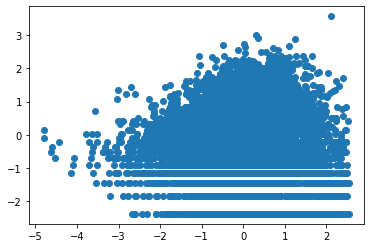

In [162]:
plt.scatter(df.NMD, df.intron_counts)

In [163]:
model, r2 = run_regression(df, ['chRNA', 'NMD', 'gene_length'], 
                           'polyA', robust = False)

print(get_var_explained(model.params, r2))


{'chRNA': 0.7546122686136385, 'NMD': 0.018561542080832823, 'CDS_length': 0.007495717596712217}


In [164]:
model, r2 = run_regression(df, ['chRNA', 'gene_length', 'intron_counts'], 
                           'polyA', robust = False)
print(get_var_explained(model.params, r2))


{'chRNA': 0.7610225495256862, 'CDS_length': 0.001909597264335497, 'intron_counts': 0.01815578084029895}


In [165]:
model, r2 = run_regression(df, ['chRNA', 'gene_length', 'NMD', 'intron_counts'], 
                           'polyA', robust = False)
print(get_var_explained(model.params, r2))


{'chRNA': 0.7602439635491938, 'CDS_length': 0.0008498234428218901, 'NMD': 0.015063551765916564, 'intron_counts': 0.017618836198068193}


In [62]:
model, r2 = run_regression(df, ['chRNA', 'gene_length', 'NMD_counts_interaction'], 
                           'polyA', robust = False)
print(get_var_explained(model.params, r2))


{'chRNA': 0.7589079877921433, 'CDS_length': 0.0009400041499205697, 'NMD_counts_interaction': 0.03389100076835187}


In [63]:
model, r2 = run_regression(df, ['chRNA'], 'polyA')

df['residuals'] = zscore(model.resid)

model2, r22 = run_regression(df, ['NMD', 'gene_length'], 'residuals')

var = get_var_explained(model2.params, r22)
print(var)

{'NMD': 0.06200173208800069, 'CDS_length': 0.03189335421402267}


In [64]:
model2, r22 = run_regression(df, ['gene_length', 'intron_counts'], 'residuals')

var = get_var_explained(model2.params, r22)
print(var)


{'CDS_length': 0.013742316347112258, 'intron_counts': 0.08648413862903809}


In [65]:
model, r2 = run_regression(df, ['chRNA'], 'polyA')

df['residuals'] = zscore(model.resid)

model2, r22 = run_regression(df, ['NMD_counts_interaction', 'gene_length'], 'residuals')

var = get_var_explained(model2.params, r22)
print(var)

{'NMD_counts_interaction': 0.15108661471806992, 'CDS_length': 0.004021618908049202}


In [66]:
model, r2 = run_regression(df, ['chRNA'], 'polyA')

df['residuals'] = zscore(model.resid)

model2, r22 = run_regression(df, ['NMD', 'intron_counts', 'gene_length'], 'residuals')

var = get_var_explained(model2.params, r22)
print(var)

{'NMD': 0.0667384884853737, 'intron_counts': 0.08520285909349772, 'CDS_length': 0.0036195405583997983}


In [67]:
0.0667384884853737+0.08520285909349772

0.1519413475788714

In [68]:
model, r2 = run_regression(df, ['chRNA'], 'polyA')

df['residuals'] = zscore(model.resid)

model2, r22 = run_regression(df, ['NMD', 'intron_counts', 'gene_length', 
                                  'NMD_counts_interaction'], 'residuals')

var = get_var_explained(model2.params, r22)
print(var)

{'NMD': 0.029118927003510594, 'intron_counts': 0.047117150640297666, 'CDS_length': 0.006926739235536223, 'NMD_counts_interaction': 0.07239807125792673}


In [69]:
0.029118927003510594 + 0.047117150640297666 + 0.07239807125792673

0.14863414890173499

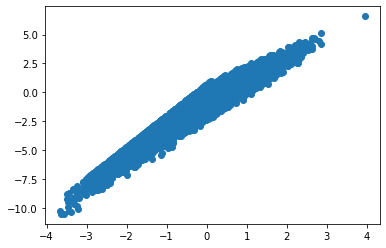

In [70]:
plt.scatter(df.NMD_counts_interaction, np.log2(NMD*intron_counts))

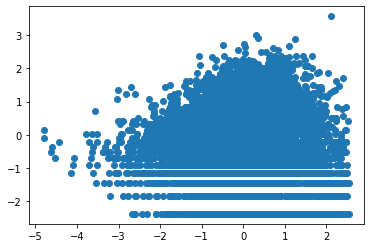

In [71]:
plt.scatter(df.NMD, df.intron_counts)

In [72]:
model, r2 = run_regression(df, ['chRNA', 'NMD', 'gene_length'], 
                           'polyA', robust = False)

print(get_var_explained(model.params, r2))


{'chRNA': 0.7546122686136385, 'NMD': 0.018561542080832823, 'CDS_length': 0.007495717596712217}


In [73]:
r2

0.7806695282911835

In [74]:
model, r2 = run_regression(df, ['chRNA', 'NMD', 'NMD_counts_interaction', 'intron_counts', 'gene_length'], 
                           'polyA', robust = False)

print(get_var_explained(model.params, r2))


{'chRNA': 0.7758942121423406, 'NMD': 0.0036815945231280355, 'NMD_counts_interaction': 0.008323118227748451, 'intron_counts': 0.0050099323039549705, 'CDS_length': 0.000867317758828393}


In [75]:
r2

0.7937761749560005

In [76]:
from sklearn.linear_model import LinearRegression

def run_LR(df, X, y):
    LR = LinearRegression()
    LR.fit(df[X], df[y])
    r2 = LR.score(df[X], df[y])
    return LR, r2

In [77]:
LR, r2 = run_LR(df, ['chRNA', 'NMD', 'NMD_counts_interaction', 'intron_counts', 'gene_length'], 
                           'polyA')

In [78]:
LR.coef_

array([ 8.60513202e-01,  1.29592250e+12, -1.86732444e+12,  1.29592250e+12,
       -1.92951403e-02])

In [79]:
r2

0.7936920409258817

In [80]:
model.params.iloc[1:]

chRNA                     0.860513
NMD                      -0.059275
NMD_counts_interaction   -0.089125
intron_counts            -0.069147
CDS_length               -0.028770
dtype: float64

In [81]:
def get_var_explained(coef, r2):

    var_explained_dict = {}
    for x in coef.index:
        if x == 'const':
            continue
        var_explained = float((coef.loc[x]**2 / (coef.iloc[1:]**2).sum()) * r2)
        var_explained_dict.update({x:var_explained})
    return var_explained_dict


In [82]:
import statsmodels.formula.api as smf

In [83]:
model2 = smf.ols('polyA ~ chRNA + NMD + intron_counts + gene_length + NMD:intron_counts', data=df)

In [84]:
res = model2.fit()

In [85]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  polyA   R-squared:                       0.795
Model:                            OLS   Adj. R-squared:                  0.795
Method:                 Least Squares   F-statistic:                     6311.
Date:                Fri, 24 Feb 2023   Prob (F-statistic):               0.00
Time:                        11:52:15   Log-Likelihood:                -5077.7
No. Observations:                8119   AIC:                         1.017e+04
Df Residuals:                    8113   BIC:                         1.021e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            -0.0016      0.005     -0.327      0.744      -0.011       0.008
chRNA                 0.8554      0.006    152.493      0.000       0.844       0.866
NMD                  -0.1055      0.006    -18.429      0.000      -0.117      -0.094
intron_counts        -0.1396      0.006    -23.901      0.000      -0.151      -0.128
CDS_length           -0.0275      0.006     -4.887      0.000      -0.038      -0.016
NMD:intron_counts     0.0431      0.005      8.203      0.000       0.033       0.053
==============================================================================
Omnibus:                      811.139   Durbin-Watson:                   1.930
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1952.718
Skew:                          -0.596   Prob(JB):                         0.00
Kurtosis:                       5.086   Cond. No.                         1.96
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [86]:
H3K27AC_TSS = pd.read_csv('../code/featureCounts/H3K27AC/Counts.txt',
                                 sep='\t', skiprows = 1)
H3K27AC_names = [x.split('27AC/')[1].split('.1')[0] for x in H3K27AC_TSS.columns if ('Alignments' in x)]

H3K27AC = pd.read_csv('../code/QTLs/QTLTools/H3K27AC/CountsPeaksAtTSS.bed.gz',#'../../H3K27AC.TSS.PeakCounts.bed.gz', 
                      sep='\t',
                     names = ['chrom', 'start', 'end', 'transcript_id', 'ensembl_id', 'strand',
                             'gene_id', 'chrom_', 'start_', 'end_', 'peak_id', 'peak_len',
                             'strand_'] + H3K27AC_names + ['overlap_len'])
                     
H3K27AC_samples = H3K27AC.columns.intersection(chRNA_log2RPKM.columns)
H3K27AC = H3K27AC.groupby(['ensembl_id', 'peak_id']).max()
H3K27AC_counts = H3K27AC.groupby('ensembl_id')[H3K27AC_samples].sum()
h3k27ac_CPM = H3K27AC_counts.divide(H3K27AC_counts.sum(axis=0), axis=1)*1e6

h3k27ac_CPM = h3k27ac_CPM.loc[h3k27ac_CPM.median(axis=1) > 0]

h3k27ac_idx = genes_idx.intersection(h3k27ac_CPM.index)
h3k27ac_log2RPKM = np.log2(h3k27ac_CPM.loc[h3k27ac_idx]) 
h3k27ac_log2RPKM = h3k27ac_log2RPKM.loc[h3k27ac_log2RPKM.median(axis=1) > -1e100]
h3k27ac_idx = h3k27ac_log2RPKM.index
h3k27ac_polyA_log2_difference = h3k27ac_log2RPKM - polyA_log2RPKM.loc[h3k27ac_idx]

In [87]:
h3k27ac_polyA_log2_difference

,NA18486,NA18498,NA18499,NA18502,NA18505,NA18508,NA18510,NA18511,NA18519,NA18520,...,NA19152,NA19153,NA19190,NA19200,NA19201,NA19206,NA19209,NA19210,NA19225,NA19257
ENSG00000000457.14,NaN,4.580675,4.407755,4.894574,4.628363,5.751624,4.269157,4.832359,4.916111,5.040994,...,4.982818,5.076733,4.586679,4.694859,4.809700,5.030251,4.650325,5.080778,4.942591,5.148509
ENSG00000000460.17,NaN,2.221821,2.211563,2.703570,2.542763,2.745021,2.493675,2.495586,2.262467,1.967640,...,2.463938,2.722007,2.190390,2.738824,2.456794,3.423248,2.757628,2.445741,2.752917,2.452239
ENSG00000000938.13,NaN,-1.464431,0.002194,-0.104340,-0.112343,1.175510,-1.195699,-0.516351,0.588221,-0.860026,...,-1.096936,0.122593,-1.267519,-1.105227,-0.378524,-1.931854,-0.366627,-2.096847,-0.684426,0.471809
ENSG00000001036.14,NaN,-1.015196,-0.158490,-0.296834,-0.496034,-1.333764,-0.041587,-0.310958,-0.406600,-0.717073,...,-0.736034,-0.624263,-0.206882,-0.301399,-0.492152,-0.432233,-0.548839,-1.031614,-0.664123,-1.061938
ENSG00000001084.13,NaN,2.344904,1.999798,2.378405,1.632477,1.706193,2.472025,2.291874,2.128315,1.174286,...,3.105623,2.053296,0.926171,0.895809,1.673700,2.073780,2.130405,2.409790,3.063980,2.882287
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSG00000285077.2,NaN,5.729969,5.906218,6.903162,5.860755,5.490954,5.466693,4.556890,6.602886,6.358361,...,6.881258,5.196963,5.514820,5.128476,5.337734,5.151116,5.490827,6.624726,6.898608,7.701662
ENSG00000285130.2,NaN,19.189535,18.859796,19.354321,15.804044,18.766476,19.513705,19.223171,18.592945,16.636864,...,19.602441,18.817224,19.029473,17.247719,19.088772,19.445463,18.381638,18.961546,19.300659,16.362400
ENSG00000285458.1,NaN,11.720165,14.800376,9.318546,9.835733,10.503116,8.500368,9.289809,10.790027,10.332636,...,9.189409,10.094839,10.296362,10.315292,10.346829,9.548168,9.951378,10.133557,9.902437,9.707613
ENSG00000285976.2,NaN,10.770089,6.824337,7.003139,9.252115,8.384385,10.538949,6.672300,6.947846,5.913576,...,7.838220,6.295515,7.703867,10.114691,5.835434,9.883255,6.226721,7.492171,6.493123,6.013500


In [152]:
genes_chRNA_expression = chRNA_log2RPKM.loc[genes_idx].median(axis=1)
exp_Q1, exp_Q2, exp_Q3, exp_Q4 = get_series_quantile(genes_chRNA_expression, quant=4)

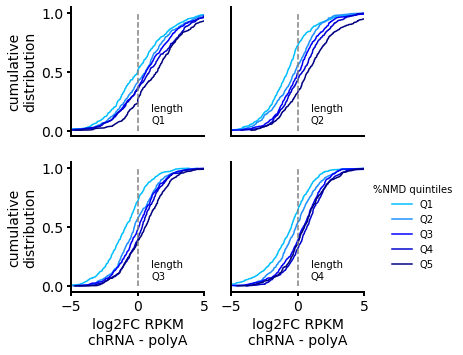

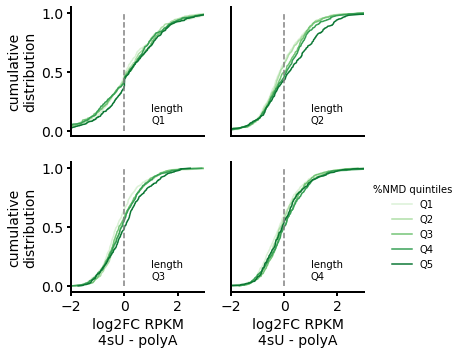

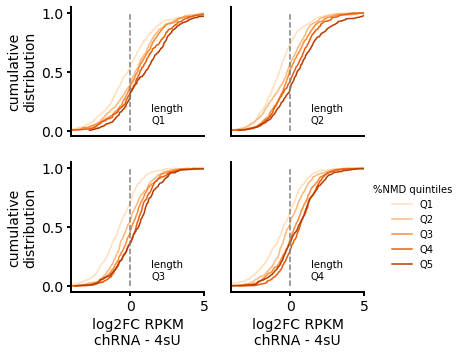

In [153]:
# Next, for each quartile we separate the genes into NMD quintiles

NMD_ratio_quant_lenQ1_genes = get_series_quantile(chRNA_juncs_NMD_ratio.mean(axis=1), exp_Q1, quant=5)
NMD_ratio_quant_lenQ2_genes = get_series_quantile(chRNA_juncs_NMD_ratio.mean(axis=1), exp_Q2, quant=5)
NMD_ratio_quant_lenQ3_genes = get_series_quantile(chRNA_juncs_NMD_ratio.mean(axis=1), exp_Q3, quant=5)
NMD_ratio_quant_lenQ4_genes = get_series_quantile(chRNA_juncs_NMD_ratio.mean(axis=1), exp_Q4, quant=5)

quartile_list = [NMD_ratio_quant_lenQ1_genes,
                 NMD_ratio_quant_lenQ2_genes,
                 NMD_ratio_quant_lenQ3_genes,
                 NMD_ratio_quant_lenQ4_genes]

multiplot_quartiles(chRNA_polyA_log2_difference, quartile_list, 
                    ['deepskyblue', 'dodgerblue', 'blue', 'mediumblue', 'navy'],
                   xlabel = 'log2FC RPKM\nchRNA - polyA', legend_title = '%NMD quintiles')

multiplot_quartiles(ml30_polyA_log2_difference, quartile_list, 
                    sns.color_palette("Greens", 5),
                   xlabel = 'log2FC RPKM\n4sU - polyA', xlim=[-2,3], legend_title = '%NMD quintiles')

multiplot_quartiles(chRNA_ml30_log2_difference, quartile_list, 
                    sns.color_palette("Oranges", 5),
                   xlabel = 'log2FC RPKM\nchRNA - 4sU', xlim=[-4,5], legend_title = '%NMD quintiles')

In [154]:
df = pd.DataFrame()
df['polyA'] = zscore(polyA_log2RPKM.loc[exp_Q1].median(axis=1))
df['chRNA'] = zscore(chRNA_log2RPKM.loc[exp_Q1].median(axis=1))
df['NMD'] = zscore(np.log2(chRNA_juncs_NMD_ratio.loc[exp_Q1].mean(axis=1)))
df['ml30'] = zscore(ml30_log2RPKM.loc[exp_Q1].median(axis=1))
df['H3K36ME3'] = zscore(h3k36me3_log2RPKM.loc[exp_Q1].median(axis=1))
df['gene_length'] = zscore(np.log2(CDS_len.loc[exp_Q1]))

model, r2 = run_regression(df, ['chRNA', 'NMD', 'CDS_length'], 'polyA', robust = False)

print(get_var_explained(model.params, r2))



{'chRNA': 0.5396143567574645, 'NMD': 0.026375569660727374, 'CDS_length': 0.005779340956150777}


In [155]:
model, r2 = run_regression(df, ['chRNA'], 'polyA')

df['residuals'] = zscore(model.resid)

model2, r22 = run_regression(df, ['NMD', 'gene_length'], 'residuals')

var = get_var_explained(model2.params, r22)
print(var)

{'NMD': 0.0444021849946681, 'CDS_length': 0.011403413525243853}


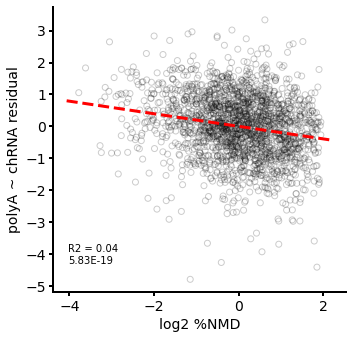

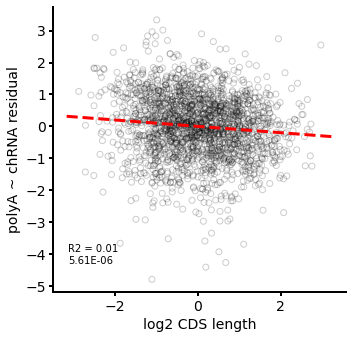

In [156]:
plot_regression(df.NMD, df.residuals, model2.params.loc['NMD'], var['NMD'], 
                model2.pvalues.loc['NMD'], xlabel='log2 %NMD', 
                ylabel='polyA ~ chRNA residual')

plot_regression(df.gene_length, df.residuals, model2.params.loc['gene_length'], var['gene_length'], 
                model2.pvalues.loc['gene_length'], xlabel='log2 gene length', 
                ylabel='polyA ~ chRNA residual')

In [157]:
df = pd.DataFrame()
df['polyA'] = zscore(polyA_log2RPKM.loc[exp_Q3].median(axis=1))
df['chRNA'] = zscore(chRNA_log2RPKM.loc[exp_Q3].median(axis=1))
df['NMD'] = zscore(np.log2(chRNA_juncs_NMD_ratio.loc[exp_Q3].mean(axis=1)))
df['ml30'] = zscore(ml30_log2RPKM.loc[exp_Q3].median(axis=1))
df['H3K36ME3'] = zscore(h3k36me3_log2RPKM.loc[exp_Q3].median(axis=1))
df['Cgene_length'] = zscore(np.log2(Cgene_len.loc[exp_Q3]))

model, r2 = run_regression(df, ['chRNA', 'NMD', 'Cgene_length'], 'polyA', robust = False)

print(get_var_explained(model.params, r2))



{'chRNA': 0.05879383047216019, 'NMD': 0.07849599264948957, 'CDS_length': 0.05615292385337186}


In [158]:
model, r2 = run_regression(df, ['chRNA'], 'polyA')

df['residuals'] = zscore(model.resid)

model2, r22 = run_regression(df, ['NMD', 'gene_length'], 'residuals')

var = get_var_explained(model2.params, r22)
print(var)

{'NMD': 0.08586415271275467, 'CDS_length': 0.061703119906287206}


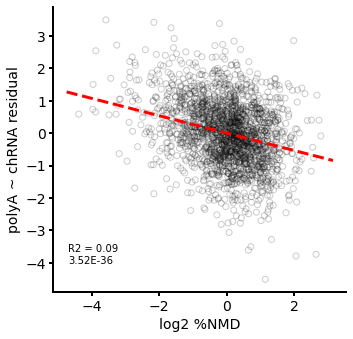

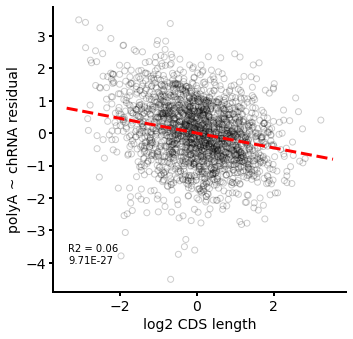

In [159]:
plot_regression(df.NMD, df.residuals, model2.params.loc['NMD'], var['NMD'], 
                model2.pvalues.loc['NMD'], xlabel='log2 %NMD', 
                ylabel='polyA ~ chRNA residual')

plot_regression(df.gene_length, df.residuals, model2.params.loc['gene_length'], var['gene_length'], 
                model2.pvalues.loc['gene_length'], xlabel='log2 gene length', 
                ylabel='polyA ~ chRNA residual')